In [2]:
import os
import csv
import optuna
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Input, Conv1D, MaxPooling1D, LSTM, Dense, Activation, Dropout
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from datetime import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from math import sqrt
from matplotlib import pyplot as plt
from matplotlib.patches import Patch
from numpy import array
import keras.backend as K
import itertools
#!pip install pydot
    
# date-time parsing function for loading the dataset
def parser(x):
    return datetime.strptime('190'+x, '%Y-%m')
    
def rmse (y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))
    
def mape (y_true, y_pred):
    return 100*K.mean(K.sqrt(K.square(y_true - y_pred))/y_true)
    
def pearson (y_true, y_pred):
    return (K.square(K.mean((y_true - K.mean(y_true))*(y_pred - K.mean(y_pred)))))/(K.mean(K.square(y_true - K.mean(y_true)))*K.mean(K.square(y_pred - K.mean(y_pred))))
    
# convert time series into a supervised learning problem
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
# convert time series into a supervised learning problem
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):

    n_vars = 1 if type(data) is list else data.shape[1]
    cols, names = list(), list()
    df = DataFrame(data)
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
    	cols.append(df.shift(i))
    	names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df[0].shift(-i)) # df[0] for temperatures
        if i == 0:
            names += [('var%d(t)' % (1))] # % (1) for temperatures
        else:            
            names += [('var%d(t+%d)' % (1, i))] # % (1) for temperatures
    
    # put it all together
    agg = concat(cols, axis=1)

    if dropnan:
        #Drop rows containing NaN
        agg.dropna(inplace=True)

    agg.columns = names

    return agg
     
# create a differenced series
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)
     
# transform series into training sets for supervised learning
def prepare_training_data(data, n_lag, n_seq, n_time_steps):
    
    #Prepare data for time series forecasting.
        
    #Parameters:
    #x (array-like): Input features.
    #y (array-like): Target values.
    #n_test (int): Number of test samples (rows).
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations.
    #n_train (int): Number of training samples (rows).
        
    #Returns:
    #tuple: Training and test datasets.
    
    n_vars = len(data[0][0])

    # Each weather station has 227 time steps (the first 180 have no nan values)
    # Loop through data, grabbing one weather station (ws) at a time, 
    # differencing on each ws and separating by training (first 226-n_lag-n_seq-n_test time steps) 
    # and testing (n_test time steps) to scale data on training only.
    # We then recombine the training and testing datasets to change each ws to a supervised learning problem by taking all the first 180 time steps for all 12 predictors
    # and changing these to (t-n_lag) to (t-1) since we lose one row through differencing. We then shift forward only one dependent variable (temperature or specific humidity)
    # for time steps t to (t+n_seq)

    diff_values = []
    
    for ws in range(84):
        
        # transform data to be stationary
        diff_series = difference(data[ws], 1)
        for i in range(len(diff_series)):
            diff_values_row = []
            for j in range(len(diff_series[0])):
                diff_values_row.append(diff_series[i][j])
            diff_values.append(diff_values_row)

    # rescale values to 0, 1
    scaler_all_features =  MinMaxScaler(feature_range=(0, 1))
    scaler =  MinMaxScaler(feature_range=(0, 1))
    #diff_values_training = np.array(diff_values_for_training)
    #diff_values_training = diff_values_training.reshape(1, -1) 
    train_scaled_values = scaler_all_features.fit_transform(diff_values)
    response_train_values = []
    for i in range(len(diff_values)):
        response_train_values.append(diff_values[i][0]) # Uses first column (temperatures) as response variable
    response_train_values = np.array(response_train_values)
    response_train_values = response_train_values.reshape(len(response_train_values), 1)

    # Fit the scaler for just the response variable for use later when forecasting
    response_scaled_values = scaler.fit_transform(response_train_values) 
    scaled_values = scaler_all_features.transform(diff_values)

    train = []

    # Transform each weather station as a separate "batch"
    for ws in range(84):
        # transform into supervised learning problem X, y
        first = (n_time_steps-1)*ws
        last = (n_time_steps-1)*ws+(n_time_steps-2)
        scaled_values_batch = scaled_values[first:last]
        supervised = series_to_supervised(scaled_values_batch, n_lag, n_seq)
        supervised_values = supervised.values
        train.append([supervised_values])
    
    return scaler, scaler_all_features, train

# transform series into testing and validation sets for supervised learning
def prepare_testing_and_validation_data(data, n_lag, n_seq, n_time_steps, scaler_all_features):
    
    #Prepare data for time series forecasting.
        
    #Parameters:
    #x (array-like): Input features.
    #y (array-like): Target values.
    #n_test (int): Number of test samples (rows).
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations.
    #n_train (int): Number of training samples (rows).
        
    #Returns:
    #tuple: Training and test datasets.
    
    n_vars = len(data[0][0])

    # Each weather station has 227 time steps (the first 180 have no nan values)
    # Loop through data, grabbing one weather station (ws) at a time, 
    # differencing on each ws and separating by training (first 226-n_lag-n_seq-n_test time steps) 
    # and testing (n_test time steps) to scale data on training only.
    # We then recombine the training and testing datasets to change each ws to a supervised learning problem by taking all the first 180 time steps for all 12 predictors
    # and changing these to (t-n_lag) to (t-1) since we lose one row through differencing. We then shift forward only one dependent variable (temperature or specific humidity)
    # for time steps t to (t+n_seq)

    diff_values = []
    
    for ws in range(21):
        
        # transform data to be stationary
        diff_series = difference(data[ws], 1)
        for i in range(len(diff_series)):
            diff_values_row = []
            for j in range(len(diff_series[0])):
                diff_values_row.append(diff_series[i][j])
            diff_values.append(diff_values_row)

    # rescale values to 0, 1
    scaled_values = scaler_all_features.transform(diff_values)

    validation = []
    test = []

    # Transform each weather station as a separate "batch"
    for ws in range(21):
        # transform into supervised learning problem X, y
        first = (n_time_steps-1)*ws
        last = (n_time_steps-1)*ws+(n_time_steps-2)
        scaled_values_batch = scaled_values[first:last]
        supervised = series_to_supervised(scaled_values_batch, n_lag, n_seq)
        supervised_values = supervised.values
        # training/test/validation split is 80%/10%/10%
        if ws < 11:
            test.append([supervised_values])
        else:
            validation.append([supervised_values])
    
    return validation, test
    
def plot_kfold(cv, X, y, ax, n_splits, xlim_max=105):
    
    #Plots the indices for a cross-validation object.
    #Taken from https://www.geeksforgeeks.org/cross-validation-using-k-fold-with-scikit-learn/
    
    #Parameters:
    #cv: Cross-validation object
    #X: Feature set
    #y: Target variable
    #ax: Matplotlib axis object
    #n_splits: Number of folds in the cross-validation
    #xlim_max: Maximum limit for the x-axis
        
    # Set color map for the plot
    cmap_cv = plt.cm.coolwarm
    cv_split = cv.split(X=X, y=y)
        
    for i_split, (train_idx, test_idx) in enumerate(cv_split):
        # Create an array of NaNs and fill in training/testing indices
        indices = np.full(len(X), np.nan)
        indices[test_idx], indices[train_idx] = 1, 0
            
        # Plot the training and testing indices
        ax_x = range(len(indices))
        ax_y = [i_split + 0.5] * len(indices)
        ax.scatter(ax_x, ax_y, c=indices, marker="_", 
                   lw=10, cmap=cmap_cv, vmin=-0.2, vmax=1.2)
    
        # Set y-ticks and labels
        y_ticks = np.arange(n_splits) + 0.5
        ax.set(yticks=y_ticks, yticklabels=range(n_splits),
               xlabel="Weather Station index (file_id)", ylabel="Fold",
               ylim=[n_splits, -0.2], xlim=[0, xlim_max])
    
        # Set plot title and create legend
        ax.set_title("KFold", fontsize=14)
        legend_patches = [Patch(color=cmap_cv(0.8), label="Testing set"), 
                          Patch(color=cmap_cv(0.02), label="Training set")]
        ax.legend(handles=legend_patches, loc=(1.03, 0.8))
    
#Main

#Configure
n_seq = 1
if n_seq > 46:
    n_lag = 179 - n_seq + 46
else:
    n_lag = 179
n_time_steps = 227
n_test = 1

print("Model Parameters:")
print("n_lag (number of input time steps): "+str(n_lag))
print("n_seq (number of output/future prediction time steps): "+str(n_seq))

# Create 2D array with file_ids to use for sample creation
array = np.array([
    6501, 6541, 6640, 6668, 6678, 
    6687, 6697, 6714, 6744, 6772, 
    6783, 6840, 6844, 6854, 6870, 
    6891, 6895, 6899, 6901, 6909, 
    6929, 6950, 6963, 6969, 6994, 
    7032, 7057, 7094, 7095, 7100, 
    7108, 7116, 7119, 7131, 7139, 
    7152, 7155, 7156, 7182, 7193, 
    7202, 7239, 7280, 7286, 7287, 
    7311, 7321, 7329, 7347, 7350, 
    7354, 7357, 7361, 7414, 7423, 
    7424, 7432, 7463, 7482, 7489, 
    7528, 7531, 7534, 7538, 7549, 
    7553, 7555, 7562, 7571, 7573, 
    7574, 7575, 7585, 7599, 7603, 
    7606, 7622, 7652, 7671, 7704, 
    7786, 7805, 7816, 7838, 7861, 
    7862, 7863, 7870, 7892, 7907, 
    7938, 7962, 7979, 7987, 7999, 
    8000, 8034, 8083, 8120, 8133, 
    8184, 8186, 8247, 8248, 9858])
    
#Create arrays holding the 5-fold cross-validation indices gathered for consistency across models
train_array = []
test_array = []
    
train_array.append([1, 2, 3, 5, 6, 7, 8, 9, 11, 13, 14, 15, 16, 17, 19, 20, 21, 22, 
                        23, 24, 25, 27, 28, 29, 32, 34, 35, 36, 37, 38, 39, 40, 41, 42, 
                        43, 44, 46, 48, 49, 50, 51, 52, 54, 55, 56, 57, 58, 59, 60, 61, 
                        62, 63, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 78, 79, 81, 
                        82, 83, 84, 85, 86, 87, 88, 90, 91, 92, 93, 95, 97, 98, 100, 101, 102, 103])
test_array.append([0, 4, 10, 12, 18, 26, 30, 31, 33, 45, 47, 53, 64, 65, 77, 80, 89, 94, 96, 99, 104])
    
train_array.append([0, 1, 2, 3, 4, 6, 7, 8, 10, 12, 13, 14, 17, 18, 19, 20, 21, 23, 
                        24, 25, 26, 27, 29, 30, 31, 32, 33, 34, 36, 37, 38, 41, 43, 45, 
                        46, 47, 48, 49, 50, 51, 52, 53, 54, 57, 58, 59, 60, 61, 63, 64, 
                        65, 66, 67, 68, 69, 70, 71, 73, 74, 75, 77, 80, 81, 82, 83, 84, 
                        86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 104])
test_array.append([5, 9, 11, 15, 16, 22, 28, 35, 39, 40, 42, 44, 55, 56, 62, 72, 76, 78, 79, 85, 103])
    
train_array.append([0, 1, 2, 4, 5, 9, 10, 11, 12, 14, 15, 16, 18, 20, 21, 22, 23, 26, 
                    28, 29, 30, 31, 32, 33, 35, 36, 37, 39, 40, 41, 42, 44, 45, 46, 47, 
                    48, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 
                    70, 71, 72, 74, 75, 76, 77, 78, 79, 80, 82, 83, 85, 86, 87, 88, 89, 
                    90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104])
test_array.append([3, 6, 7, 8, 13, 17, 19, 24, 25, 27, 34, 38, 43, 49, 66, 67, 68, 69, 73, 81, 84])
    
train_array.append([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 
                        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 33, 34, 
                        35, 37, 38, 39, 40, 42, 43, 44, 45, 47, 49, 51, 52, 53, 55, 56, 
                        60, 62, 64, 65, 66, 67, 68, 69, 71, 72, 73, 74, 76, 77, 78, 79, 
                        80, 81, 82, 84, 85, 86, 87, 88, 89, 92, 93, 94, 95, 96, 99, 102, 103, 104])
test_array.append([32, 36, 41, 46, 48, 50, 54, 57, 58, 59, 61, 63, 70, 75, 83, 90, 91, 97, 98, 100, 101])
    
train_array.append([0, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 22,
                        24, 25, 26, 27, 28, 30, 31, 32, 33, 34, 35, 36, 38, 39, 40, 41, 
                        42, 43, 44, 45, 46, 47, 48, 49, 50, 53, 54, 55, 56, 57, 58, 59, 
                        61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 72, 73, 75, 76, 77, 78, 
                        79, 80, 81, 83, 84, 85, 89, 90, 91, 94, 96, 97, 98, 99, 100, 101, 103, 104])
test_array.append([1, 2, 14, 20, 21, 23, 29, 37, 51, 52, 60, 71, 74, 82, 86, 87, 88, 92, 93, 95, 102])
    
# Equations for three Principal Components from PCA using response variables combined with other predictors
#PC1=-0.0002714X1+0.02612X2+0.03858X3-0.007658X4+0.001592X5-0.02087X6+0.8564X7-0.1468X8+0.01192X9-0.0001049X10+0.01913X11+0.02076X12
#PC2=0.0003944X1+0.002204X2+0.01052X3+0.3248X4-0.0009976X5-0.04421X6+2.3406X7+0.06103X8+0.08841X9+0.00009018X10+0.05678X11-0.002022X12
#PC3=-0.00007998X1-0.0006124X2-0.001063X3-0.01855X4+0.00001956X5+0.01170X6+0.6076X7+0.4664X8-0.002995X9+0.008185X10+0.8815X11-0.0004730X12
    
# Equations for three Principal Components from PCA omitting both response variables,
#PC-1=-0.0004514X1+0.03194X2-0.04343X3+0.002243X4-0.02252X5+0.9877X6-0.2265X7+0.006144X8-0.0001488X9+0.02943X10
#PC-2=0.0001702X1+0.005484X2+0.2057X3-0.0003188X4-0.02584X5+1.6963X6-0.05890X7+0.05809X8+1.9748X9+0.03686X10
#PC-3=-0.00006323X1-0.001180X2-0.02384X3-0.00002833X4+0.01170X5+0.5204X6+0.4791X7-0.004318X8+0.008271X9+0.8765X10
    
# Get the current working directory 
current_directory = os.getcwd() 
    
# Print the current working directory 
print(current_directory)
    
# Define the directory containing the files 
path = current_directory+"\\Modeling\\"
print(path)
    
filename = path + 'Final_Monthly_Dataset.csv'
    
# load dataset
df = read_csv(filename, header=0, parse_dates=[0], index_col=0, date_format='%Y-%m')

print(df)
    
df = df.rename(columns={'Unnamed: 0' : 'indices'})
    
#Remove unused columns
df = df.drop(['Day', 'vapor_pressure'], axis=1)
    
# Round numbers in columns to reasonable precision,
df['temperatures'] = np.round(df['temperatures'], 2)
df['slp'] = np.round(df['slp'], 2)
df['wet_bulb_temperature'] = np.round(df['wet_bulb_temperature'], 2)
df['specific_humidity'] = np.round(df['specific_humidity'], 2)
df['GHI'] = np.round(df['GHI'], 2)
df['PRCP'] = np.round(df['PRCP'], 2)
df['SNDP'] = np.round(df['SNDP'], 2)
df['solar_activity'] = np.round(df['solar_activity'], 2)
df['ONI'] = np.round(df['ONI'], 2)
df['water'] = np.round(df['water'], 0)
df['region'] = np.round(df['region'], 0)
    
df_trimmed = df[df['file_id'] != 7533] # Remove file_id 7533 so there are 105 weather stations for 5-fold CV
df_trimmed = df_trimmed.drop(['Year', 'Month', 'date', 'latitude', 'longitude', 'elevation'], axis=1)

#Test model and accuracy when solar activity is removed as a predictor
df_trimmed = df_trimmed.drop(['solar_activity'], axis=1)

n_vars = df_trimmed.shape[1]-1

X = []
y = []
    
for i in array:
    add_to_X = [] # create list to store each column to add to X
    new_df = df_trimmed[df_trimmed['file_id'] == i].drop(['file_id'], axis=1)
    add_to_y = []
    for j in range(new_df.shape[0]):
        add_to_y.append(new_df['temperatures'].iloc[j])
    y.append(add_to_y)
    columns_list = new_df.columns.tolist()
    for j in range(new_df.shape[0]):
        l=0
        new_row = []
        for m in columns_list:
            new_row.append(new_df.iloc[j, l])
            l += 1
        add_to_X.append(new_row)
    X.append(add_to_X)
    
#Perform k-fold cross-validation
#Taken from: https://www.geeksforgeeks.org/cross-validation-using-k-fold-with-scikit-learn/
    
#k = 5  # Number of folds
#kf = KFold(n_splits=k, shuffle=True, random_state=42)
    
#for i, (train_index, test_index) in enumerate(kf.split(X)):
#    print(f"Fold {i}:")
#    print(f"  Training dataset index: {train_index}")
#    print(f"  Test dataset index: {test_index}")
    
#for train_indices, test_indices in kf.split(X):
#    print('Train: %s | test: %s' % (train_indices, test_indices))
    
# Create figure and axis
#fig, ax = plt.subplots(figsize=(6, 3))
#plot_kfold(kf, X, y, ax, k)
#plt.tight_layout()
#fig.subplots_adjust(right=0.6)
    
#Create train and test sets for each cross-validation split
train_X = []
train_y = []
val_X = []
val_y = []
for i in range(5):
    print(f"Fold {i+1}")
    #Add each corresponding sample for each entry of train index 
    train_X_rows = [] # Stores all the samples for one fold of train_X
    train_y_rows = [] # Stores all the samples for one fold of train_y
    for j in train_array[i]:
        train_X_rows.append(X[j])
        train_y_rows.append(y[j])
    # Stores one fold of train dataset
    train_X.append(train_X_rows)
    train_y.append(train_y_rows)
    #Add each corresponding sample for each entry of the validation index 
    val_X_rows = [] # Stores all the samples for one fold of val_X
    val_y_rows = [] # Stores all the samples for one fold of val_y
    for j in test_array[i]: 
            val_X_rows.append(X[j])
            val_y_rows.append(y[j])
    # Stores one fold of validation dataset
    val_X.append(val_X_rows)
    val_y.append(val_y_rows) 
    
#Convert 3D arrays to DataFrames
df_X = []
df_y = []
val_df_X = []
val_df_y = []
dataset = []
dataset_test = []
scaler = []
scaler_all_features = []
train = []
test = []
validation = []

for i in range(5):
    dataset_scaling = [] # Holds all 84 weather station rows to train the scaling function
    dataset_testing = [] # Holds remaining 21 weather station rows for testing and validation
    print("Fold "+str(i+1)+":")
    #Transform train_X to the correct format
    df1 = []
    dataset_df = [] # captures each weather station's dataset as values for training scaler mapping
    df_X.append(pd.DataFrame(train_X[i]))
    X_t = df_X[i].transpose()
    for k in range(84):
        X = np.array(X_t.iloc[:, k])
        df = pd.DataFrame()
        for j in range(n_time_steps):
            new_row = pd.DataFrame(X[j]).transpose()
            new_row.columns = new_df.columns
            # Add the new row
            df = pd.concat([df, new_row], ignore_index=True)
        df.columns = new_df.columns
        df1.append(df)
        dataset_df.append(df.values)
        dataset_scaling.append(df.values)
    df_X[i] = df1
    dataset.append(dataset_df) 
    
    #Transform train_y to the correct format
    df2 = []
    df_y.append(pd.DataFrame(train_y[i]))
    y_t = df_y[i].transpose()
    
    for j in range(84):
        y = np.array(y_t.iloc[:, j])
        y = pd.DataFrame(y)
        y.columns = ['temperatures']
        df2.append(y)
    df_y[i] = df2

    #Transform val_X to the correct format
    df3 = []
    dataset_vl_df = [] # captures each weather station's dataset as values for training scaler mapping
    val_df_X.append(pd.DataFrame(val_X[i]))
    val_X_t = val_df_X[i].transpose()
    for k in range(21):
        vl_X = np.array(val_X_t.iloc[:, k])
        vl_df = pd.DataFrame()
        for j in range(n_time_steps):
            new1_row = pd.DataFrame(vl_X[j]).transpose()
            new1_row.columns = new_df.columns
            # Add the new row
            vl_df = pd.concat([vl_df, new1_row], ignore_index=True)
        vl_df.columns = new_df.columns
        df3.append(vl_df)
        dataset_vl_df.append(vl_df.values)
        dataset_testing.append(vl_df.values)
    val_df_X[i] = df3
    dataset_test.append(dataset_vl_df)

    #Transform val_y to the correct format
    df4 = []
    val_df_y.append(pd.DataFrame(train_y[i]))
    val_y_t = val_df_y[i].transpose()
    
    for j in range(21):
        v_y = np.array(val_y_t.iloc[:, j])
        v_y = pd.DataFrame(v_y)
        v_y.columns = ['temperatures']
        df4.append(v_y)
    val_df_y[i] = df4
    
    scaler.append(MinMaxScaler(feature_range=(0, 1)))
    scaler_all_features.append(MinMaxScaler(feature_range=(0, 1)))
    train.append([1])
    test.append([1])
    validation.append([1])
    
    # prepare data
    scaler[i], scaler_all_features[i], train[i] = prepare_training_data(dataset_scaling, n_lag, n_seq, n_time_steps)

    validation[i], test[i] = prepare_testing_and_validation_data(dataset_testing, n_lag, n_seq, n_time_steps, scaler_all_features[i])

    #Reshape dimensionality
    train1 = train[i]
    test1 = test[i]
    validation1 = validation[i]
    print(np.array(train1).shape)
    print(np.array(test1).shape)
    print(np.array(validation1).shape)
    train2 = []
    test2 = []
    validation2 = []

    for k in range(84):
        train2.append(train1[k][0])
        
    for k in range(11):
        test2.append(test1[k][0])

    for k in range(10):
        validation2.append(validation1[k][0])

    print(np.array(train2).shape)
    print(np.array(test2).shape)
    print(np.array(validation2).shape)

    train[i] = train2
    test[i] = test2
    validation[i] = validation2

    #Reshape dimensionality (again)
    dim_size = n_seq + n_vars*n_lag
    train1 = np.array(train[i]).reshape(84, dim_size)
    test1 = np.array(test[i]).reshape(11, dim_size)
    validation1 = np.array(validation[i]).reshape(10, dim_size)
    train2 = pd.DataFrame(train1).values
    test2 = pd.DataFrame(test1).values
    validation2 = pd.DataFrame(validation1).values
    print(np.array(train2).shape)
    print(np.array(test2).shape)
    print(np.array(validation2).shape)

    print(train2)

    train[i] = train2
    test[i] = test2
    validation[i] = validation2
    
print("Finished")

Model Parameters:
n_lag (number of input time steps): 179
n_seq (number of output/future prediction time steps): 1
C:\Users\User
C:\Users\User\Modeling\
             date  file_id  temperatures          slp  vapor_pressure  \
0      2006-01-31     6501     12.209677  1018.534543        8.674922   
1      2006-02-28     6501      8.174541  1021.230347        6.942276   
2      2006-03-31     6501     15.676613  1018.968548       10.468176   
3      2006-04-30     6501     22.464167  1014.686944       16.358802   
4      2006-05-31     6501     23.657258  1014.236828       18.798749   
...           ...      ...           ...          ...             ...   
24057  2024-07-31     9858     28.604704  1013.969355       23.769169   
24058  2024-08-31     9858     29.114919  1015.112097       23.699154   
24059  2024-09-30     9858     24.570278  1014.393750       16.790240   
24060  2024-10-31     9858     21.159140  1018.230376       10.994776   
24061  2024-11-30     9858     12.112917  10

In [2]:
print(n_seq)
print(n_lag)
print(np.array(train[1]).shape)
print(np.array(test[1]).shape)

1
179
(84, 1970)
(11, 1970)


[I 2025-05-20 02:15:35,537] A new study created in memory with name: no-name-bdfdf73f-d896-4d7d-9748-f73547c341e1
[I 2025-05-20 02:21:11,559] Trial 0 finished with value: 0.035905982553958896 and parameters: {'lr': 0.005035870843137267, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.20928675268428273}. Best is trial 0 with value: 0.035905982553958896.


Cross Validation Accuracies:
[0.04392772540450096, 0.025146521627902985, 0.033185217529535294, 0.04160205274820328, 0.03566839545965195]
Mean Cross Validation Accuracy:
0.035905982553958896
Standard Deviation of Cross Validation Accuracy:
0.006633529729831832


[I 2025-05-20 02:24:18,760] Trial 1 finished with value: 0.13553352504968644 and parameters: {'lr': 0.052893805698585816, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.3459694767761583}. Best is trial 0 with value: 0.035905982553958896.


Cross Validation Accuracies:
[0.12000200897455215, 0.151082843542099, 0.11122353374958038, 0.15225699543952942, 0.1431022435426712]
Mean Cross Validation Accuracy:
0.13553352504968644
Standard Deviation of Cross Validation Accuracy:
0.016798481691437914


[I 2025-05-20 02:31:07,356] Trial 2 finished with value: 18.47602171897888 and parameters: {'lr': 0.5909793243600696, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 256, 'dropout_rate': 0.38556032781413985}. Best is trial 0 with value: 0.035905982553958896.


Cross Validation Accuracies:
[3.2873494625091553, 35.57413101196289, 24.582134246826172, 8.234297752380371, 20.70219612121582]
Mean Cross Validation Accuracy:
18.47602171897888
Standard Deviation of Cross Validation Accuracy:
11.577344071842955


[I 2025-05-20 02:38:37,568] Trial 3 finished with value: 0.0675932414829731 and parameters: {'lr': 0.13345414472395412, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 256, 'dropout_rate': 0.29877384409694574}. Best is trial 0 with value: 0.035905982553958896.


Cross Validation Accuracies:
[0.05783778801560402, 0.08348367363214493, 0.046435557305812836, 0.06938979029655457, 0.08081939816474915]
Mean Cross Validation Accuracy:
0.0675932414829731
Standard Deviation of Cross Validation Accuracy:
0.013953358837157202


[I 2025-05-20 02:48:35,778] Trial 4 finished with value: 0.036898065358400345 and parameters: {'lr': 0.04244623289147937, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'filters': 1024, 'lstm_units': 512, 'dropout_rate': 0.39885105166361934}. Best is trial 0 with value: 0.035905982553958896.


Cross Validation Accuracies:
[0.04399041831493378, 0.033190783113241196, 0.029825758188962936, 0.044844429939985275, 0.03263893723487854]
Mean Cross Validation Accuracy:
0.036898065358400345
Standard Deviation of Cross Validation Accuracy:
0.006250565146292587


[I 2025-05-20 02:56:17,707] Trial 5 finished with value: 0.33873342275619506 and parameters: {'lr': 0.6475682033453565, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'filters': 1024, 'lstm_units': 512, 'dropout_rate': 0.3802766669439832}. Best is trial 0 with value: 0.035905982553958896.


Cross Validation Accuracies:
[0.33362439274787903, 0.3386663496494293, 0.35378578305244446, 0.3405119776725769, 0.32707861065864563]
Mean Cross Validation Accuracy:
0.33873342275619506
Standard Deviation of Cross Validation Accuracy:
0.008850741658588852


[I 2025-05-20 03:06:16,283] Trial 6 finished with value: 0.09465815871953964 and parameters: {'lr': 0.0014769573952958814, 'optimizer': 'RMSprop', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 1024, 'dropout_rate': 0.31768672277567445}. Best is trial 0 with value: 0.035905982553958896.


Cross Validation Accuracies:
[0.0831262394785881, 0.10758061707019806, 0.07932116836309433, 0.11162687093019485, 0.09163589775562286]
Mean Cross Validation Accuracy:
0.09465815871953964
Standard Deviation of Cross Validation Accuracy:
0.012901702366897794


[I 2025-05-20 03:13:12,778] Trial 7 finished with value: 35.69243392944336 and parameters: {'lr': 0.3455932573402087, 'optimizer': 'RMSprop', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 512, 'dropout_rate': 0.28069678307760376}. Best is trial 0 with value: 0.035905982553958896.


Cross Validation Accuracies:
[17.434429168701172, 42.23775100708008, 41.553165435791016, 42.34710693359375, 34.88971710205078]
Mean Cross Validation Accuracy:
35.69243392944336
Standard Deviation of Cross Validation Accuracy:
9.54435031185183


[I 2025-05-20 03:20:42,816] Trial 8 finished with value: 3.4899370670318604 and parameters: {'lr': 0.1145903520686524, 'optimizer': 'RMSprop', 'activation_function': 'sigmoid', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.35821312265830463}. Best is trial 0 with value: 0.035905982553958896.


Cross Validation Accuracies:
[3.067213535308838, 3.3957860469818115, 3.894387722015381, 3.270430088043213, 3.8218679428100586]
Mean Cross Validation Accuracy:
3.4899370670318604
Standard Deviation of Cross Validation Accuracy:
0.31921821730128525


[I 2025-05-20 03:27:27,964] Trial 9 finished with value: 0.07524281218647957 and parameters: {'lr': 0.04363474329000235, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.4586571769975989}. Best is trial 0 with value: 0.035905982553958896.


Cross Validation Accuracies:
[0.028432108461856842, 0.03791933134198189, 0.11911796778440475, 0.09758663922548294, 0.09315801411867142]
Mean Cross Validation Accuracy:
0.07524281218647957
Standard Deviation of Cross Validation Accuracy:
0.035579529370991535


[I 2025-05-20 03:33:50,391] Trial 10 finished with value: 0.03158232867717743 and parameters: {'lr': 0.004986480441563711, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.15397860616273776}. Best is trial 10 with value: 0.03158232867717743.


Cross Validation Accuracies:
[0.032995469868183136, 0.027858497574925423, 0.028993042185902596, 0.03651703521609306, 0.03154759854078293]
Mean Cross Validation Accuracy:
0.03158232867717743
Standard Deviation of Cross Validation Accuracy:
0.003063358465648624


[I 2025-05-20 03:39:35,776] Trial 11 finished with value: 0.029775632545351982 and parameters: {'lr': 0.004728854756176109, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.14377305089555265}. Best is trial 11 with value: 0.029775632545351982.


Cross Validation Accuracies:
[0.025613058358430862, 0.03463788330554962, 0.020716136321425438, 0.019631322473287582, 0.048279762268066406]
Mean Cross Validation Accuracy:
0.029775632545351982
Standard Deviation of Cross Validation Accuracy:
0.010661639853054823


[I 2025-05-20 03:47:48,560] Trial 12 finished with value: 0.036354506760835646 and parameters: {'lr': 0.0070883678890604805, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.10800358952147501}. Best is trial 11 with value: 0.029775632545351982.


Cross Validation Accuracies:
[0.025477616116404533, 0.05401511490345001, 0.034200362861156464, 0.040791284292936325, 0.027288155630230904]
Mean Cross Validation Accuracy:
0.036354506760835646
Standard Deviation of Cross Validation Accuracy:
0.010360771049407339


[I 2025-05-20 03:58:15,545] Trial 13 finished with value: 0.035576021298766136 and parameters: {'lr': 0.007915021333369972, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.10515046249381446}. Best is trial 11 with value: 0.029775632545351982.


Cross Validation Accuracies:
[0.02548367530107498, 0.040240004658699036, 0.031015409156680107, 0.04717558994889259, 0.03396542742848396]
Mean Cross Validation Accuracy:
0.035576021298766136
Standard Deviation of Cross Validation Accuracy:
0.0075040172856060666


[I 2025-05-20 04:10:45,334] Trial 14 finished with value: 0.018181739002466203 and parameters: {'lr': 0.0013008437155633918, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.17676850103264646}. Best is trial 14 with value: 0.018181739002466203.


Cross Validation Accuracies:
[0.018518608063459396, 0.019774815067648888, 0.02308979071676731, 0.013925590552389622, 0.015599890612065792]
Mean Cross Validation Accuracy:
0.018181739002466203
Standard Deviation of Cross Validation Accuracy:
0.003210018208174804


[I 2025-05-20 04:21:31,782] Trial 15 finished with value: 0.02049044780433178 and parameters: {'lr': 0.0010709215631522393, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.2178042267862017}. Best is trial 14 with value: 0.018181739002466203.


Cross Validation Accuracies:
[0.020903607830405235, 0.019046412780880928, 0.02635413222014904, 0.018320247530937195, 0.0178278386592865]
Mean Cross Validation Accuracy:
0.02049044780433178
Standard Deviation of Cross Validation Accuracy:
0.0031124906416025292


[I 2025-05-20 04:32:45,360] Trial 16 finished with value: 0.03014613054692745 and parameters: {'lr': 0.0012484618374336688, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.22702912499000033}. Best is trial 14 with value: 0.018181739002466203.


Cross Validation Accuracies:
[0.025643188506364822, 0.02445167489349842, 0.03228487819433212, 0.04078228026628494, 0.027568630874156952]
Mean Cross Validation Accuracy:
0.03014613054692745
Standard Deviation of Cross Validation Accuracy:
0.00595060902974705


[I 2025-05-20 04:43:42,598] Trial 17 finished with value: 0.023325391486287116 and parameters: {'lr': 0.0021193671167637086, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.23197023562507357}. Best is trial 14 with value: 0.018181739002466203.


Cross Validation Accuracies:
[0.016895899549126625, 0.04213855415582657, 0.020945273339748383, 0.020178452134132385, 0.016468778252601624]
Mean Cross Validation Accuracy:
0.023325391486287116
Standard Deviation of Cross Validation Accuracy:
0.009569271559680377


[I 2025-05-20 04:53:26,070] Trial 18 finished with value: 0.031525957956910135 and parameters: {'lr': 0.015480960595545275, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.18944203683946736}. Best is trial 14 with value: 0.018181739002466203.


Cross Validation Accuracies:
[0.025484783574938774, 0.024058789014816284, 0.038247000426054, 0.040665704756975174, 0.029173512011766434]
Mean Cross Validation Accuracy:
0.031525957956910135
Standard Deviation of Cross Validation Accuracy:
0.006730464847086205


[I 2025-05-20 05:03:26,272] Trial 19 finished with value: 0.034595702216029166 and parameters: {'lr': 0.0024773539311491537, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.2636293184309344}. Best is trial 14 with value: 0.018181739002466203.


Cross Validation Accuracies:
[0.029657870531082153, 0.034490812569856644, 0.04041854292154312, 0.041231121867895126, 0.02718016318976879]
Mean Cross Validation Accuracy:
0.034595702216029166
Standard Deviation of Cross Validation Accuracy:
0.005609236498399596


[I 2025-05-20 05:12:39,125] Trial 20 finished with value: 0.0301215223968029 and parameters: {'lr': 0.0010042730493478504, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.17526289960701555}. Best is trial 14 with value: 0.018181739002466203.


Cross Validation Accuracies:
[0.0261699091643095, 0.024898119270801544, 0.03168020769953728, 0.040522683411836624, 0.027336692437529564]
Mean Cross Validation Accuracy:
0.0301215223968029
Standard Deviation of Cross Validation Accuracy:
0.005679227334622581


[I 2025-05-20 05:22:16,732] Trial 21 finished with value: 0.024852380529046057 and parameters: {'lr': 0.002271663012136935, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.24107853106665392}. Best is trial 14 with value: 0.018181739002466203.


Cross Validation Accuracies:
[0.019699446856975555, 0.018340805545449257, 0.019451789557933807, 0.03270525485277176, 0.034064605832099915]
Mean Cross Validation Accuracy:
0.024852380529046057
Standard Deviation of Cross Validation Accuracy:
0.006995033198083866


[I 2025-05-20 05:32:07,154] Trial 22 finished with value: 0.021301553770899772 and parameters: {'lr': 0.0029609195988724484, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.24637342302724666}. Best is trial 14 with value: 0.018181739002466203.


Cross Validation Accuracies:
[0.02238789014518261, 0.018180198967456818, 0.0205648485571146, 0.026912488043308258, 0.018462343141436577]
Mean Cross Validation Accuracy:
0.021301553770899772
Standard Deviation of Cross Validation Accuracy:
0.0031940387444998088


[I 2025-05-20 05:42:05,052] Trial 23 finished with value: 0.03242589831352234 and parameters: {'lr': 0.015087469363181179, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.1943137490871532}. Best is trial 14 with value: 0.018181739002466203.


Cross Validation Accuracies:
[0.03058711811900139, 0.029785575345158577, 0.030310463160276413, 0.04435150697827339, 0.027094827964901924]
Mean Cross Validation Accuracy:
0.03242589831352234
Standard Deviation of Cross Validation Accuracy:
0.0060904505080551395


[I 2025-05-20 05:51:12,026] Trial 24 finished with value: 0.033719705417752266 and parameters: {'lr': 0.0031246606888191896, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 256, 'dropout_rate': 0.1467466392965502}. Best is trial 14 with value: 0.018181739002466203.


Cross Validation Accuracies:
[0.027610372751951218, 0.03629482164978981, 0.03170431777834892, 0.045751020312309265, 0.027237994596362114]
Mean Cross Validation Accuracy:
0.033719705417752266
Standard Deviation of Cross Validation Accuracy:
0.006852475024851999


[I 2025-05-20 06:02:17,686] Trial 25 finished with value: 0.025137489289045335 and parameters: {'lr': 0.0010224332578403147, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.25569697772725275}. Best is trial 14 with value: 0.018181739002466203.


Cross Validation Accuracies:
[0.01785503700375557, 0.03772256523370743, 0.02021789364516735, 0.01814105175435543, 0.03175089880824089]
Mean Cross Validation Accuracy:
0.025137489289045335
Standard Deviation of Cross Validation Accuracy:
0.008103184469887156


[I 2025-05-20 06:10:37,119] Trial 26 finished with value: 0.030785946175456047 and parameters: {'lr': 0.014390615801918593, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.3113597861877603}. Best is trial 14 with value: 0.018181739002466203.


Cross Validation Accuracies:
[0.026441752910614014, 0.024033425375819206, 0.03480776399374008, 0.04066343232989311, 0.02798335626721382]
Mean Cross Validation Accuracy:
0.030785946175456047
Standard Deviation of Cross Validation Accuracy:
0.006100210058025397


[I 2025-05-20 06:19:14,753] Trial 27 finished with value: 0.026839902624487877 and parameters: {'lr': 0.0018075506151578494, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.21280163079354628}. Best is trial 14 with value: 0.018181739002466203.


Cross Validation Accuracies:
[0.02807660773396492, 0.026612913236021996, 0.02665351703763008, 0.027909183874726295, 0.024947291240096092]
Mean Cross Validation Accuracy:
0.026839902624487877
Standard Deviation of Cross Validation Accuracy:
0.001126147729359864


[I 2025-05-20 06:26:00,991] Trial 28 finished with value: 0.08573045879602433 and parameters: {'lr': 0.004060509513573828, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'filters': 512, 'lstm_units': 256, 'dropout_rate': 0.1593826324092043}. Best is trial 14 with value: 0.018181739002466203.


Cross Validation Accuracies:
[0.0707927793264389, 0.0844208151102066, 0.10033217072486877, 0.09414006024599075, 0.07896646857261658]
Mean Cross Validation Accuracy:
0.08573045879602433
Standard Deviation of Cross Validation Accuracy:
0.010531214422491523


[I 2025-05-20 06:34:50,884] Trial 29 finished with value: 0.17821604683995246 and parameters: {'lr': 0.009875375911336793, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.20610581260214478}. Best is trial 14 with value: 0.018181739002466203.


Cross Validation Accuracies:
[0.05643780529499054, 0.1382995843887329, 0.2032041698694229, 0.441342830657959, 0.051795843988657]
Mean Cross Validation Accuracy:
0.17821604683995246
Standard Deviation of Cross Validation Accuracy:
0.14301429469273993


[I 2025-05-20 06:42:53,341] Trial 30 finished with value: 0.02790178097784519 and parameters: {'lr': 0.0033855152344765224, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.27453656846379965}. Best is trial 14 with value: 0.018181739002466203.


Cross Validation Accuracies:
[0.018734440207481384, 0.032909687608480453, 0.03153081610798836, 0.025170767679810524, 0.03116319328546524]
Mean Cross Validation Accuracy:
0.02790178097784519
Standard Deviation of Cross Validation Accuracy:
0.005298762222845748


[I 2025-05-20 06:51:19,693] Trial 31 finished with value: 0.018768645450472833 and parameters: {'lr': 0.0018150825171328374, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.22549521984196508}. Best is trial 14 with value: 0.018181739002466203.


Cross Validation Accuracies:
[0.02065226249396801, 0.0183733981102705, 0.018589075654745102, 0.020202934741973877, 0.01602555625140667]
Mean Cross Validation Accuracy:
0.018768645450472833
Standard Deviation of Cross Validation Accuracy:
0.001632066362852212


[I 2025-05-20 06:59:03,448] Trial 32 finished with value: 0.0257972564548254 and parameters: {'lr': 0.0017735994126457056, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.21984476586696824}. Best is trial 14 with value: 0.018181739002466203.


Cross Validation Accuracies:
[0.03471602872014046, 0.017527151852846146, 0.02864639088511467, 0.03203209862112999, 0.016064612194895744]
Mean Cross Validation Accuracy:
0.0257972564548254
Standard Deviation of Cross Validation Accuracy:
0.007611232711974621


[I 2025-05-20 07:06:17,873] Trial 33 finished with value: 0.01913740374147892 and parameters: {'lr': 0.0028899090016002763, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.18182343993821282}. Best is trial 14 with value: 0.018181739002466203.


Cross Validation Accuracies:
[0.018002724274992943, 0.01739840768277645, 0.030257465317845345, 0.01560578029602766, 0.014422641135752201]
Mean Cross Validation Accuracy:
0.01913740374147892
Standard Deviation of Cross Validation Accuracy:
0.005703835987032737


[I 2025-05-20 07:13:25,665] Trial 34 finished with value: 0.02461380958557129 and parameters: {'lr': 0.0014529667298883182, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.13426852413993245}. Best is trial 14 with value: 0.018181739002466203.


Cross Validation Accuracies:
[0.0322180911898613, 0.0350731797516346, 0.02245951071381569, 0.017850514501333237, 0.015467751771211624]
Mean Cross Validation Accuracy:
0.02461380958557129
Standard Deviation of Cross Validation Accuracy:
0.007762178309688772


[I 2025-05-20 07:19:40,558] Trial 35 finished with value: 0.035896523669362065 and parameters: {'lr': 0.023456109467493783, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.17284232127277896}. Best is trial 14 with value: 0.018181739002466203.


Cross Validation Accuracies:
[0.03249874338507652, 0.03324773535132408, 0.038777198642492294, 0.04816626384854317, 0.026792677119374275]
Mean Cross Validation Accuracy:
0.035896523669362065
Standard Deviation of Cross Validation Accuracy:
0.007215065138794085


[I 2025-05-20 07:27:00,093] Trial 36 finished with value: 0.12155302911996842 and parameters: {'lr': 0.006297596455829488, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'filters': 1024, 'lstm_units': 256, 'dropout_rate': 0.18794900455008345}. Best is trial 14 with value: 0.018181739002466203.


Cross Validation Accuracies:
[0.12632368505001068, 0.09618621319532394, 0.14141161739826202, 0.11637309193611145, 0.12747053802013397]
Mean Cross Validation Accuracy:
0.12155302911996842
Standard Deviation of Cross Validation Accuracy:
0.01498296831323264


[I 2025-05-20 07:36:52,755] Trial 37 finished with value: 0.04575283527374267 and parameters: {'lr': 0.07831196080885076, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.1259909677666688}. Best is trial 14 with value: 0.018181739002466203.


Cross Validation Accuracies:
[0.041301243007183075, 0.03370239958167076, 0.03872259706258774, 0.058966830372810364, 0.05607110634446144]
Mean Cross Validation Accuracy:
0.04575283527374267
Standard Deviation of Cross Validation Accuracy:
0.009955202737755306


[I 2025-05-20 07:45:28,371] Trial 38 finished with value: 0.021355289220809936 and parameters: {'lr': 0.0015752160958505167, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 512, 'dropout_rate': 0.289975330621456}. Best is trial 14 with value: 0.018181739002466203.


Cross Validation Accuracies:
[0.017991241067647934, 0.022809408605098724, 0.02138722687959671, 0.025462443009018898, 0.019126126542687416]
Mean Cross Validation Accuracy:
0.021355289220809936
Standard Deviation of Cross Validation Accuracy:
0.0026559435860025135


[I 2025-05-20 07:55:48,520] Trial 39 finished with value: 0.04999194070696831 and parameters: {'lr': 0.0010102176175632485, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.3416182018416434}. Best is trial 14 with value: 0.018181739002466203.


Cross Validation Accuracies:
[0.03713131323456764, 0.07738413661718369, 0.03628769516944885, 0.04904608428478241, 0.05011047422885895]
Mean Cross Validation Accuracy:
0.04999194070696831
Standard Deviation of Cross Validation Accuracy:
0.014862322672363903


[I 2025-05-20 08:03:04,764] Trial 40 finished with value: 0.0566327765583992 and parameters: {'lr': 0.002283025234195707, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.168570648157242}. Best is trial 14 with value: 0.018181739002466203.


Cross Validation Accuracies:
[0.05473233759403229, 0.07663583010435104, 0.05960480868816376, 0.053768590092659, 0.03842231631278992]
Mean Cross Validation Accuracy:
0.0566327765583992
Standard Deviation of Cross Validation Accuracy:
0.012266957413045005


[I 2025-05-20 08:12:23,283] Trial 41 finished with value: 0.02665742188692093 and parameters: {'lr': 0.0031159739656720993, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.20294393208360723}. Best is trial 14 with value: 0.018181739002466203.


Cross Validation Accuracies:
[0.03818031772971153, 0.023428164422512054, 0.0320965014398098, 0.022101154550909996, 0.017480971291661263]
Mean Cross Validation Accuracy:
0.02665742188692093
Standard Deviation of Cross Validation Accuracy:
0.00745326286028256


[I 2025-05-20 08:20:26,019] Trial 42 finished with value: 0.03837924525141716 and parameters: {'lr': 0.232955511902098, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.24743492424550917}. Best is trial 14 with value: 0.018181739002466203.


Cross Validation Accuracies:
[0.036062564700841904, 0.04614607244729996, 0.03584158793091774, 0.04668654128909111, 0.02715945988893509]
Mean Cross Validation Accuracy:
0.03837924525141716
Standard Deviation of Cross Validation Accuracy:
0.007307873414039448


[I 2025-05-20 08:28:28,152] Trial 43 finished with value: 0.02105024755001068 and parameters: {'lr': 0.0027873835177035324, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.23613874510539545}. Best is trial 14 with value: 0.018181739002466203.


Cross Validation Accuracies:
[0.022363493219017982, 0.017859941348433495, 0.020042814314365387, 0.028250794857740402, 0.01673419401049614]
Mean Cross Validation Accuracy:
0.02105024755001068
Standard Deviation of Cross Validation Accuracy:
0.004083963497831017


[I 2025-05-20 08:38:29,324] Trial 44 finished with value: 0.032716712728142736 and parameters: {'lr': 0.004472518992717019, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.22195943561538428}. Best is trial 14 with value: 0.018181739002466203.


Cross Validation Accuracies:
[0.02057611010968685, 0.03215805068612099, 0.03956107422709465, 0.044768739491701126, 0.026519589126110077]
Mean Cross Validation Accuracy:
0.032716712728142736
Standard Deviation of Cross Validation Accuracy:
0.008697210007734517


[I 2025-05-20 08:48:26,742] Trial 45 finished with value: 0.03728606514632702 and parameters: {'lr': 0.0014146711129071076, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'filters': 1024, 'lstm_units': 512, 'dropout_rate': 0.2652691383309551}. Best is trial 14 with value: 0.018181739002466203.


Cross Validation Accuracies:
[0.04785116761922836, 0.022922353819012642, 0.029785174876451492, 0.053765248507261276, 0.03210638090968132]
Mean Cross Validation Accuracy:
0.03728606514632702
Standard Deviation of Cross Validation Accuracy:
0.011598220218918825


[I 2025-05-20 08:58:31,804] Trial 46 finished with value: 0.14003778398036956 and parameters: {'lr': 0.009190790809438123, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.41879640848596045}. Best is trial 14 with value: 0.018181739002466203.


Cross Validation Accuracies:
[0.08754394203424454, 0.26103681325912476, 0.04026417434215546, 0.2642645239830017, 0.04707946628332138]
Mean Cross Validation Accuracy:
0.14003778398036956
Standard Deviation of Cross Validation Accuracy:
0.10141466705526518


[I 2025-05-20 09:07:30,112] Trial 47 finished with value: 0.032422516494989395 and parameters: {'lr': 0.005820310328066125, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.19055056400930048}. Best is trial 14 with value: 0.018181739002466203.


Cross Validation Accuracies:
[0.026735099032521248, 0.020904427394270897, 0.033884160220623016, 0.04578927904367447, 0.034799616783857346]
Mean Cross Validation Accuracy:
0.032422516494989395
Standard Deviation of Cross Validation Accuracy:
0.0083841570014096


[I 2025-05-20 09:17:16,158] Trial 48 finished with value: 0.030552782118320465 and parameters: {'lr': 0.0018167885738651919, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.12193080946681664}. Best is trial 14 with value: 0.018181739002466203.


Cross Validation Accuracies:
[0.025681300088763237, 0.026427241042256355, 0.03319467231631279, 0.040407512336969376, 0.027053184807300568]
Mean Cross Validation Accuracy:
0.030552782118320465
Standard Deviation of Cross Validation Accuracy:
0.005605245742596641


[I 2025-05-20 09:28:15,909] Trial 49 finished with value: 15.14666166305542 and parameters: {'lr': 0.8719803258026514, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 1024, 'lstm_units': 1024, 'dropout_rate': 0.49634671355557114}. Best is trial 14 with value: 0.018181739002466203.


Cross Validation Accuracies:
[19.35940933227539, 17.257719039916992, 17.913328170776367, 3.2938895225524902, 17.90896224975586]
Mean Cross Validation Accuracy:
15.14666166305542
Standard Deviation of Cross Validation Accuracy:
5.966184068294119


[I 2025-05-20 09:36:09,244] Trial 50 finished with value: 0.02720261886715889 and parameters: {'lr': 0.0013173887787885626, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.2359398959372939}. Best is trial 14 with value: 0.018181739002466203.


Cross Validation Accuracies:
[0.018032973632216454, 0.020669586956501007, 0.03443216532468796, 0.025975925847887993, 0.03690244257450104]
Mean Cross Validation Accuracy:
0.02720261886715889
Standard Deviation of Cross Validation Accuracy:
0.007411080857459221


[I 2025-05-20 09:46:00,457] Trial 51 finished with value: 0.02769412249326706 and parameters: {'lr': 0.0032858900930629476, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.2899195858115905}. Best is trial 14 with value: 0.018181739002466203.


Cross Validation Accuracies:
[0.016034932807087898, 0.03718479722738266, 0.020197933539748192, 0.04107475280761719, 0.02397819608449936]
Mean Cross Validation Accuracy:
0.02769412249326706
Standard Deviation of Cross Validation Accuracy:
0.009747326162170094


[I 2025-05-20 09:56:07,732] Trial 52 finished with value: 0.01965259499847889 and parameters: {'lr': 0.0027988979355952877, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.23988962709925454}. Best is trial 14 with value: 0.018181739002466203.


Cross Validation Accuracies:
[0.019088495522737503, 0.016948968172073364, 0.02622871845960617, 0.019573315978050232, 0.016423476859927177]
Mean Cross Validation Accuracy:
0.01965259499847889
Standard Deviation of Cross Validation Accuracy:
0.0035016194860887947


[I 2025-05-20 10:05:59,870] Trial 53 finished with value: 0.02054193466901779 and parameters: {'lr': 0.002489561802858054, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.17816574987080716}. Best is trial 14 with value: 0.018181739002466203.


Cross Validation Accuracies:
[0.01713077537715435, 0.02080395631492138, 0.02042551524937153, 0.026598714292049408, 0.017750712111592293]
Mean Cross Validation Accuracy:
0.02054193466901779
Standard Deviation of Cross Validation Accuracy:
0.0033524235802091314


[I 2025-05-20 10:14:34,954] Trial 54 finished with value: 0.020796647667884825 and parameters: {'lr': 0.0020453157989861097, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.16118484285704837}. Best is trial 14 with value: 0.018181739002466203.


Cross Validation Accuracies:
[0.02848595567047596, 0.020950738340616226, 0.02151750959455967, 0.017617594450712204, 0.015411440283060074]
Mean Cross Validation Accuracy:
0.020796647667884825
Standard Deviation of Cross Validation Accuracy:
0.0044446750465394185


[I 2025-05-20 10:24:52,579] Trial 55 finished with value: 0.03032558560371399 and parameters: {'lr': 0.0038981903274061874, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.18630865502977167}. Best is trial 14 with value: 0.018181739002466203.


Cross Validation Accuracies:
[0.03663177788257599, 0.02181989885866642, 0.021629100665450096, 0.04356718808412552, 0.027979962527751923]
Mean Cross Validation Accuracy:
0.03032558560371399
Standard Deviation of Cross Validation Accuracy:
0.008585867483347666


[I 2025-05-20 10:36:32,690] Trial 56 finished with value: 0.04744751825928688 and parameters: {'lr': 0.0023312482112854407, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.2095047645679136}. Best is trial 14 with value: 0.018181739002466203.


Cross Validation Accuracies:
[0.054853085428476334, 0.05043132230639458, 0.03554879501461983, 0.04695240408182144, 0.04945198446512222]
Mean Cross Validation Accuracy:
0.04744751825928688
Standard Deviation of Cross Validation Accuracy:
0.006474382586180032


[I 2025-05-20 10:47:36,060] Trial 57 finished with value: 0.017488811910152436 and parameters: {'lr': 0.0012372759548607008, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.17449018411967432}. Best is trial 57 with value: 0.017488811910152436.


Cross Validation Accuracies:
[0.015734734013676643, 0.017776476219296455, 0.0208334568887949, 0.018262485042214394, 0.014836907386779785]
Mean Cross Validation Accuracy:
0.017488811910152436
Standard Deviation of Cross Validation Accuracy:
0.002096537992557129


[I 2025-05-20 10:56:38,549] Trial 58 finished with value: 0.02203749418258667 and parameters: {'lr': 0.0013287726052746095, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.15409561905941588}. Best is trial 57 with value: 0.017488811910152436.


Cross Validation Accuracies:
[0.016844255849719048, 0.025163443759083748, 0.02825015038251877, 0.02580650895833969, 0.014123111963272095]
Mean Cross Validation Accuracy:
0.02203749418258667
Standard Deviation of Cross Validation Accuracy:
0.0055169067508626605


[I 2025-05-20 11:07:00,733] Trial 59 finished with value: 0.031529777124524115 and parameters: {'lr': 0.0010863496053840078, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.13621505290289698}. Best is trial 57 with value: 0.017488811910152436.


Cross Validation Accuracies:
[0.02511342614889145, 0.029605120420455933, 0.03455278277397156, 0.04169383645057678, 0.02668371982872486]
Mean Cross Validation Accuracy:
0.031529777124524115
Standard Deviation of Cross Validation Accuracy:
0.006013398369063792


[I 2025-05-20 11:17:29,706] Trial 60 finished with value: 0.028904704749584197 and parameters: {'lr': 0.0018132951038905016, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.20001946201684434}. Best is trial 57 with value: 0.017488811910152436.


Cross Validation Accuracies:
[0.02595750242471695, 0.026512818410992622, 0.030860811471939087, 0.04269026219844818, 0.01850212924182415]
Mean Cross Validation Accuracy:
0.028904704749584197
Standard Deviation of Cross Validation Accuracy:
0.007955987012059088


[I 2025-05-20 11:28:15,762] Trial 61 finished with value: 0.03162312917411327 and parameters: {'lr': 0.002540731672620218, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.17354463018927155}. Best is trial 57 with value: 0.017488811910152436.


Cross Validation Accuracies:
[0.026338202878832817, 0.03319811820983887, 0.030551232397556305, 0.04085244983434677, 0.027175642549991608]
Mean Cross Validation Accuracy:
0.03162312917411327
Standard Deviation of Cross Validation Accuracy:
0.005225332453154534


[I 2025-05-20 11:38:13,854] Trial 62 finished with value: 0.022992302477359772 and parameters: {'lr': 0.0012277493688057871, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.22519164330765168}. Best is trial 57 with value: 0.017488811910152436.


Cross Validation Accuracies:
[0.02453770488500595, 0.01867588236927986, 0.020457888022065163, 0.03127005696296692, 0.020019980147480965]
Mean Cross Validation Accuracy:
0.022992302477359772
Standard Deviation of Cross Validation Accuracy:
0.004578185822766195


[I 2025-05-20 11:48:22,755] Trial 63 finished with value: 0.02620716243982315 and parameters: {'lr': 0.0015875881151093986, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.18587987025647837}. Best is trial 57 with value: 0.017488811910152436.


Cross Validation Accuracies:
[0.01770235225558281, 0.03160509467124939, 0.02404298074543476, 0.04072047397494316, 0.016964910551905632]
Mean Cross Validation Accuracy:
0.02620716243982315
Standard Deviation of Cross Validation Accuracy:
0.008968930624400177


[I 2025-05-20 11:59:15,892] Trial 64 finished with value: 0.026285915449261666 and parameters: {'lr': 0.005144920703042957, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.1795985328132132}. Best is trial 57 with value: 0.017488811910152436.


Cross Validation Accuracies:
[0.025486035272479057, 0.02216416411101818, 0.03866471350193024, 0.02039279043674469, 0.024721873924136162]
Mean Cross Validation Accuracy:
0.026285915449261666
Standard Deviation of Cross Validation Accuracy:
0.006450402032830869


[I 2025-05-20 12:10:28,824] Trial 65 finished with value: 0.026949671283364295 and parameters: {'lr': 0.003907954709996362, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.2172003196918791}. Best is trial 57 with value: 0.017488811910152436.


Cross Validation Accuracies:
[0.034051474183797836, 0.04019281640648842, 0.019394822418689728, 0.025226108729839325, 0.015883134678006172]
Mean Cross Validation Accuracy:
0.026949671283364295
Standard Deviation of Cross Validation Accuracy:
0.009036936857923174


[I 2025-05-20 12:21:02,720] Trial 66 finished with value: 0.02213983703404665 and parameters: {'lr': 0.0020627894167377157, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.1513016103179239}. Best is trial 57 with value: 0.017488811910152436.


Cross Validation Accuracies:
[0.01856224052608013, 0.02103307843208313, 0.036104146391153336, 0.020553946495056152, 0.0144457733258605]
Mean Cross Validation Accuracy:
0.02213983703404665
Standard Deviation of Cross Validation Accuracy:
0.007358528553251643


[I 2025-05-20 12:30:27,038] Trial 67 finished with value: 0.08874883279204368 and parameters: {'lr': 0.02661930626146599, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.2555214883116331}. Best is trial 57 with value: 0.017488811910152436.


Cross Validation Accuracies:
[0.09266311675310135, 0.18245834112167358, 0.04157393053174019, 0.10019619017839432, 0.02685258537530899]
Mean Cross Validation Accuracy:
0.08874883279204368
Standard Deviation of Cross Validation Accuracy:
0.054743862503448606


[I 2025-05-20 12:41:27,747] Trial 68 finished with value: 0.024587497860193253 and parameters: {'lr': 0.002501530597866135, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.11244071970341302}. Best is trial 57 with value: 0.017488811910152436.


Cross Validation Accuracies:
[0.01757877878844738, 0.04128647595643997, 0.022809922695159912, 0.016042223200201988, 0.02522008866071701]
Mean Cross Validation Accuracy:
0.024587497860193253
Standard Deviation of Cross Validation Accuracy:
0.008995106181569191


[I 2025-05-20 12:49:03,292] Trial 69 finished with value: 0.016947442106902598 and parameters: {'lr': 0.001289731166834595, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.20008098662471505}. Best is trial 69 with value: 0.016947442106902598.


Cross Validation Accuracies:
[0.015927664935588837, 0.019457196816802025, 0.01862134225666523, 0.016567131504416466, 0.01416387502104044]
Mean Cross Validation Accuracy:
0.016947442106902598
Standard Deviation of Cross Validation Accuracy:
0.0018991386347620295


[I 2025-05-20 12:55:48,420] Trial 70 finished with value: 0.030966846272349358 and parameters: {'lr': 0.0011990736822841425, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.20116795702745052}. Best is trial 69 with value: 0.016947442106902598.


Cross Validation Accuracies:
[0.025076575577259064, 0.02670750766992569, 0.03342452272772789, 0.04318138584494591, 0.026444239541888237]
Mean Cross Validation Accuracy:
0.030966846272349358
Standard Deviation of Cross Validation Accuracy:
0.006760567673794815


[I 2025-05-20 13:03:01,355] Trial 71 finished with value: 0.025874856673181058 and parameters: {'lr': 0.0014832494671658284, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.17320044991424768}. Best is trial 69 with value: 0.016947442106902598.


Cross Validation Accuracies:
[0.03312230482697487, 0.03080879896879196, 0.019061671569943428, 0.014912747777998447, 0.03146876022219658]
Mean Cross Validation Accuracy:
0.025874856673181058
Standard Deviation of Cross Validation Accuracy:
0.007412804744694909


[I 2025-05-20 13:10:45,739] Trial 72 finished with value: 0.0219544330611825 and parameters: {'lr': 0.001804917883333859, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.2117274968918547}. Best is trial 69 with value: 0.016947442106902598.


Cross Validation Accuracies:
[0.018725648522377014, 0.028730010613799095, 0.03134620934724808, 0.015001758001744747, 0.01596853882074356]
Mean Cross Validation Accuracy:
0.0219544330611825
Standard Deviation of Cross Validation Accuracy:
0.00676327705948681


[I 2025-05-20 13:17:23,687] Trial 73 finished with value: 0.023656333982944488 and parameters: {'lr': 0.0010150670508881506, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.16102044168126478}. Best is trial 69 with value: 0.016947442106902598.


Cross Validation Accuracies:
[0.032535653561353683, 0.020782198756933212, 0.017226794734597206, 0.018384739756584167, 0.029352283105254173]
Mean Cross Validation Accuracy:
0.023656333982944488
Standard Deviation of Cross Validation Accuracy:
0.006142889979647915


[I 2025-05-20 13:24:33,716] Trial 74 finished with value: 0.030140315368771552 and parameters: {'lr': 0.0027615709013627202, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 256, 'dropout_rate': 0.13792257916467374}. Best is trial 69 with value: 0.016947442106902598.


Cross Validation Accuracies:
[0.02531416527926922, 0.0210780780762434, 0.03449642285704613, 0.042977314442396164, 0.026835596188902855]
Mean Cross Validation Accuracy:
0.030140315368771552
Standard Deviation of Cross Validation Accuracy:
0.007747273790901214


[I 2025-05-20 13:31:25,657] Trial 75 finished with value: 0.023998586088418962 and parameters: {'lr': 0.0015996262966823179, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 512, 'dropout_rate': 0.24838311188408763}. Best is trial 69 with value: 0.016947442106902598.


Cross Validation Accuracies:
[0.024301929399371147, 0.0189385786652565, 0.019401561468839645, 0.024791782721877098, 0.03255907818675041]
Mean Cross Validation Accuracy:
0.023998586088418962
Standard Deviation of Cross Validation Accuracy:
0.0049140515566017725


[I 2025-05-20 13:43:25,330] Trial 76 finished with value: 0.049687480181455614 and parameters: {'lr': 0.0012372745813213192, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.1963938778473629}. Best is trial 69 with value: 0.016947442106902598.


Cross Validation Accuracies:
[0.032064855098724365, 0.04929070174694061, 0.04853406921029091, 0.07012384384870529, 0.04842393100261688]
Mean Cross Validation Accuracy:
0.049687480181455614
Standard Deviation of Cross Validation Accuracy:
0.012093686131766729


[I 2025-05-20 13:50:28,126] Trial 77 finished with value: 0.026331588625907898 and parameters: {'lr': 0.002010451742273778, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.2673527806286755}. Best is trial 69 with value: 0.016947442106902598.


Cross Validation Accuracies:
[0.034989725798368454, 0.030075030401349068, 0.02157384343445301, 0.0258027296513319, 0.019216613844037056]
Mean Cross Validation Accuracy:
0.026331588625907898
Standard Deviation of Cross Validation Accuracy:
0.005701147128284292


[I 2025-05-20 13:55:16,708] Trial 78 finished with value: 0.025479909777641297 and parameters: {'lr': 0.0037907297002080158, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.22363321550012166}. Best is trial 69 with value: 0.016947442106902598.


Cross Validation Accuracies:
[0.02358732372522354, 0.02891405299305916, 0.03837866336107254, 0.01712646707892418, 0.019393041729927063]
Mean Cross Validation Accuracy:
0.025479909777641297
Standard Deviation of Cross Validation Accuracy:
0.007597144636597646


[I 2025-05-20 14:00:11,386] Trial 79 finished with value: 6.578089618682862 and parameters: {'lr': 0.3471512777728279, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.1667737357708441}. Best is trial 69 with value: 0.016947442106902598.


Cross Validation Accuracies:
[12.053157806396484, 5.1391825675964355, 8.339025497436523, 4.5294108390808105, 2.8296713829040527]
Mean Cross Validation Accuracy:
6.578089618682862
Standard Deviation of Cross Validation Accuracy:
3.2678875238653107


[I 2025-05-20 14:03:55,123] Trial 80 finished with value: 0.3642554640769958 and parameters: {'lr': 0.06357137485479222, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.1829010720009076}. Best is trial 69 with value: 0.016947442106902598.


Cross Validation Accuracies:
[0.5988358855247498, 0.20619063079357147, 0.3072717487812042, 0.1881111115217209, 0.5208679437637329]
Mean Cross Validation Accuracy:
0.3642554640769958
Standard Deviation of Cross Validation Accuracy:
0.1666216739726138


[I 2025-05-20 14:08:55,250] Trial 81 finished with value: 0.018971000239253043 and parameters: {'lr': 0.002105279659210012, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.15937568100309846}. Best is trial 69 with value: 0.016947442106902598.


Cross Validation Accuracies:
[0.02145223133265972, 0.019610604271292686, 0.017318155616521835, 0.018200889229774475, 0.018273120746016502]
Mean Cross Validation Accuracy:
0.018971000239253043
Standard Deviation of Cross Validation Accuracy:
0.0014406667315920868


[I 2025-05-20 14:13:52,896] Trial 82 finished with value: 0.02409643791615963 and parameters: {'lr': 0.0015327234384280666, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.14433291311157706}. Best is trial 69 with value: 0.016947442106902598.


Cross Validation Accuracies:
[0.019500529393553734, 0.017221467569470406, 0.027017777785658836, 0.017582207918167114, 0.03916020691394806]
Mean Cross Validation Accuracy:
0.02409643791615963
Standard Deviation of Cross Validation Accuracy:
0.008321948665242062


[I 2025-05-20 14:26:02,040] Trial 83 finished with value: 0.029685034602880477 and parameters: {'lr': 0.0029095706840472323, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.20493570853513968}. Best is trial 69 with value: 0.016947442106902598.


Cross Validation Accuracies:
[0.018191859126091003, 0.045986708253622055, 0.03217848017811775, 0.02041904255747795, 0.03164908289909363]
Mean Cross Validation Accuracy:
0.029685034602880477
Standard Deviation of Cross Validation Accuracy:
0.00993751489546102


[I 2025-05-20 14:35:19,835] Trial 84 finished with value: 0.025041265040636064 and parameters: {'lr': 0.0020893329243504674, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.17908855513304098}. Best is trial 69 with value: 0.016947442106902598.


Cross Validation Accuracies:
[0.032265570014715195, 0.01793544366955757, 0.02010791376233101, 0.031113116070628166, 0.023784281685948372]
Mean Cross Validation Accuracy:
0.025041265040636064
Standard Deviation of Cross Validation Accuracy:
0.005752714431217883


[I 2025-05-20 14:40:12,569] Trial 85 finished with value: 0.03415202349424362 and parameters: {'lr': 0.012332992162554818, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.23575595449581094}. Best is trial 69 with value: 0.016947442106902598.


Cross Validation Accuracies:
[0.033196672797203064, 0.030038969591259956, 0.03088667243719101, 0.047852929681539536, 0.028784872964024544]
Mean Cross Validation Accuracy:
0.03415202349424362
Standard Deviation of Cross Validation Accuracy:
0.007000193712406736


[I 2025-05-20 14:44:00,227] Trial 86 finished with value: 0.021598506718873978 and parameters: {'lr': 0.0011305259179017935, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.1942773550104926}. Best is trial 69 with value: 0.016947442106902598.


Cross Validation Accuracies:
[0.02473358064889908, 0.017703909426927567, 0.026324929669499397, 0.021548619493842125, 0.01768149435520172]
Mean Cross Validation Accuracy:
0.021598506718873978
Standard Deviation of Cross Validation Accuracy:
0.0035406531915379894


[I 2025-05-20 14:46:39,897] Trial 87 finished with value: 0.03327101320028305 and parameters: {'lr': 0.003370864600023549, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 1024, 'lstm_units': 256, 'dropout_rate': 0.16400827156317724}. Best is trial 69 with value: 0.016947442106902598.


Cross Validation Accuracies:
[0.026013491675257683, 0.022349845618009567, 0.04609877988696098, 0.04235026240348816, 0.02954268641769886]
Mean Cross Validation Accuracy:
0.03327101320028305
Standard Deviation of Cross Validation Accuracy:
0.009304066905453627


[I 2025-05-20 14:51:16,466] Trial 88 finished with value: 0.04708235338330269 and parameters: {'lr': 0.0017414815602142457, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.15116720233356162}. Best is trial 69 with value: 0.016947442106902598.


Cross Validation Accuracies:
[0.051162246614694595, 0.048849690705537796, 0.02976198121905327, 0.05711473524570465, 0.04852311313152313]
Mean Cross Validation Accuracy:
0.04708235338330269
Standard Deviation of Cross Validation Accuracy:
0.009192266057761524


[I 2025-05-20 14:55:23,582] Trial 89 finished with value: 0.02982965372502804 and parameters: {'lr': 0.0013522391187879474, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.31647442116100394}. Best is trial 69 with value: 0.016947442106902598.


Cross Validation Accuracies:
[0.025298424065113068, 0.0239378921687603, 0.032257311046123505, 0.04044671356678009, 0.027207927778363228]
Mean Cross Validation Accuracy:
0.02982965372502804
Standard Deviation of Cross Validation Accuracy:
0.006012217946119978


[I 2025-05-20 15:03:24,041] Trial 90 finished with value: 0.08038949221372604 and parameters: {'lr': 0.007680400047428465, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.12893819539234597}. Best is trial 69 with value: 0.016947442106902598.


Cross Validation Accuracies:
[0.1677781343460083, 0.08734416961669922, 0.031923238188028336, 0.04106365516781807, 0.0738382637500763]
Mean Cross Validation Accuracy:
0.08038949221372604
Standard Deviation of Cross Validation Accuracy:
0.04821526759135788


[I 2025-05-20 15:15:50,529] Trial 91 finished with value: 0.023524818941950798 and parameters: {'lr': 0.0022321553022811554, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.21029970176056864}. Best is trial 69 with value: 0.016947442106902598.


Cross Validation Accuracies:
[0.023419689387083054, 0.018902083858847618, 0.020369429141283035, 0.02397875115275383, 0.030954141169786453]
Mean Cross Validation Accuracy:
0.023524818941950798
Standard Deviation of Cross Validation Accuracy:
0.00416504741588941


[I 2025-05-20 15:30:27,245] Trial 92 finished with value: 0.019844795390963555 and parameters: {'lr': 0.0019837343200420866, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.16273722594332615}. Best is trial 69 with value: 0.016947442106902598.


Cross Validation Accuracies:
[0.019658254459500313, 0.02334849163889885, 0.017282778397202492, 0.019333386793732643, 0.019601065665483475]
Mean Cross Validation Accuracy:
0.019844795390963555
Standard Deviation of Cross Validation Accuracy:
0.001959365148492327


[I 2025-05-20 15:41:16,973] Trial 93 finished with value: 0.035006198287010196 and parameters: {'lr': 0.005059076162138077, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.15732678820918097}. Best is trial 69 with value: 0.016947442106902598.


Cross Validation Accuracies:
[0.035301998257637024, 0.021709272637963295, 0.045289721339941025, 0.04399799183011055, 0.02873200736939907]
Mean Cross Validation Accuracy:
0.035006198287010196
Standard Deviation of Cross Validation Accuracy:
0.008976239730660486


[I 2025-05-20 15:49:18,982] Trial 94 finished with value: 0.02620697021484375 and parameters: {'lr': 0.0025158299782930336, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.11584466676678931}. Best is trial 69 with value: 0.016947442106902598.


Cross Validation Accuracies:
[0.02208884246647358, 0.017484281212091446, 0.03631465137004852, 0.02685893326997757, 0.028288142755627632]
Mean Cross Validation Accuracy:
0.02620697021484375
Standard Deviation of Cross Validation Accuracy:
0.006324015067908778


[I 2025-05-20 15:58:06,207] Trial 95 finished with value: 0.026524211466312408 and parameters: {'lr': 0.0010035519412900035, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.1920780713354079}. Best is trial 69 with value: 0.016947442106902598.


Cross Validation Accuracies:
[0.028239430859684944, 0.04115534573793411, 0.03276769444346428, 0.014501068741083145, 0.01595751754939556]
Mean Cross Validation Accuracy:
0.026524211466312408
Standard Deviation of Cross Validation Accuracy:
0.010121305534886795


[I 2025-05-20 16:05:23,388] Trial 96 finished with value: 0.02468281015753746 and parameters: {'lr': 0.0016813695173551022, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.1706351948939519}. Best is trial 69 with value: 0.016947442106902598.


Cross Validation Accuracies:
[0.021404054015874863, 0.03217925503849983, 0.019990121945738792, 0.01825222186744213, 0.03158839792013168]
Mean Cross Validation Accuracy:
0.02468281015753746
Standard Deviation of Cross Validation Accuracy:
0.005966705262480352


[I 2025-05-20 16:12:57,685] Trial 97 finished with value: 0.025026638805866242 and parameters: {'lr': 0.0014295309448794037, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.2264147356190124}. Best is trial 69 with value: 0.016947442106902598.


Cross Validation Accuracies:
[0.03467776998877525, 0.026127178221940994, 0.01821752078831196, 0.020858531817793846, 0.025252193212509155]
Mean Cross Validation Accuracy:
0.025026638805866242
Standard Deviation of Cross Validation Accuracy:
0.005623941659501977


[I 2025-05-20 16:18:59,332] Trial 98 finished with value: 0.04012355022132397 and parameters: {'lr': 0.0027865975591217225, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.1803728631532954}. Best is trial 69 with value: 0.016947442106902598.


Cross Validation Accuracies:
[0.028061039745807648, 0.02123582921922207, 0.03140723705291748, 0.07935572415590286, 0.040557920932769775]
Mean Cross Validation Accuracy:
0.04012355022132397
Standard Deviation of Cross Validation Accuracy:
0.020579487012182457


[I 2025-05-20 16:28:25,596] Trial 99 finished with value: 0.02599867805838585 and parameters: {'lr': 0.0020015365570520897, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.14570321802803837}. Best is trial 69 with value: 0.016947442106902598.


Cross Validation Accuracies:
[0.02104087546467781, 0.04452021047472954, 0.01921280100941658, 0.019470959901809692, 0.025748543441295624]
Mean Cross Validation Accuracy:
0.02599867805838585
Standard Deviation of Cross Validation Accuracy:
0.009553520488175414
Number of finished trials: 100
Best trial: {'lr': 0.001289731166834595, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.20008098662471505}
Best hyperparameters:  {'lr': 0.001289731166834595, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.20008098662471505}
Fold 1:
Epoch 1/100
84/84 [==============================] - 28s 230ms/step - loss: 0.1283 - val_loss: 0.0342
Epoch 2/100
84/84 [==============================] - 18s 216ms/step - loss: 0.0900 - val_loss: 0.0343
Epoch 3/100
84/84 [==============================] - 17s 198ms/step - loss: 0.0573 - val_loss: 0.0507
Epoch 4/100
84/84 [==============================] - 13

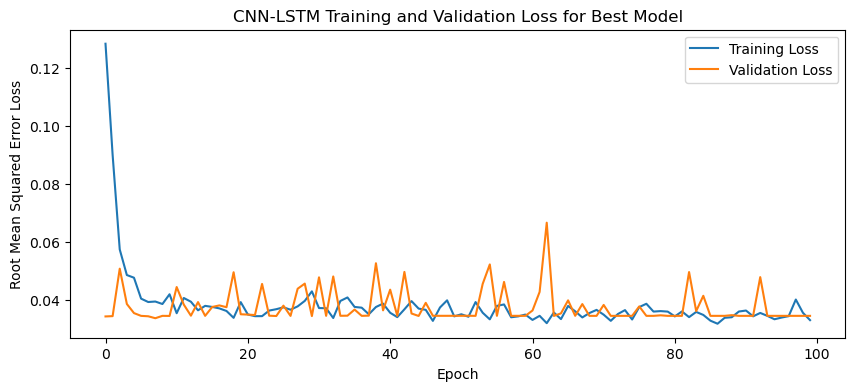

1/1 - 6s - loss: 0.0271 - 6s/epoch - 6s/step
Test Loss: 0.02711804024875164
1/1 [==============================] - 0s 88ms/step


NameError: name 'series' is not defined

In [3]:
n_batch = 1
nb_epoch = 100

def rmse (y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

def mape (y_true, y_pred):
    return 100*K.mean(K.sqrt(K.square(y_true - y_pred))/y_true)
    
def pearson (y_true, y_pred):
    return (K.square(K.mean((y_true - K.mean(y_true))*(y_pred - K.mean(y_pred)))))/(K.mean(K.square(y_true - K.mean(y_true)))*K.mean(K.square(y_pred - K.mean(y_pred))))
 
# fit an LSTM network to training data
#Adapted from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def create_model(trial, X, y, n_lag, n_seq, n_batch, nb_epoch):
    
    #Parameters:
    #trial (array-like): Optuna parameters.
    #train (array-like): Target values.
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations
    #nb_epoch (int): Maximum number of epochs
    
    # Hyperparameters to be tuned by Optuna (taken from Javier Leon's dissertation 'Fruit Prices')
    lr = trial.suggest_float('lr', 1e-3, 1, log=True)
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'RMSprop', 'SGD'])
    if optimizer_name == 'Adam':
        optimizer = Adam(learning_rate=lr)
    elif optimizer_name == 'RMSprop':
        optimizer = RMSprop(learning_rate=lr)
    else:
        optimizer = SGD(learning_rate=lr)
    
    #Optuna will try either Rectified Linear Unit (ReLU) = max(0, x), tanh, or sigmoid functions
    activation_function = trial.suggest_categorical('activation_function', ['relu', 'tanh', 'sigmoid'])
    
    filters = trial.suggest_categorical('filters', [256, 512, 1024]) # Used for CNN-LSTM model
    lstm_units = trial.suggest_categorical('lstm_units', [256, 512, 1024])
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)

    # design network
    model = Sequential()
    model.add(Conv1D(filters=filters, kernel_size=1, activation='relu', input_shape=(X.shape[1], X.shape[2]))) # CNN-LSTM only
    model.add(MaxPooling1D(pool_size=1)) # CNN-LSTM Only
    model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm_units, return_sequences=True))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm_units))
    model.add(Dropout(dropout_rate))
    model.add(Dense(256, input_dim=y.shape[1], activation=activation_function))
    model.add(Dense(128, activation=activation_function))
    model.add(Dense(n_seq))
    model.compile(loss=rmse, optimizer=optimizer)
        
    return model

# make forecast with the CNN-LSTM best model
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def forecast_lstm(model, X, n_seq, n_test):
    # reshape input pattern to [samples, timesteps, features]
    X = X.reshape(1, 1, X.shape[1])
    # make forecast
    forecast = model.predict(X)
    # convert to array
    return forecast
     
# evaluate the persistence model
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def make_forecasts(model, X_test, y_test, n_lag, n_seq, n_test):
    forecasts = list()
    for i in range(len(X_test)):
        X, y = X_test[i, :], y_test[i, :]
        # make forecast
        forecast = forecast_lstm(model, X, n_seq, n_test)
        # store the forecast
        forecasts.append(forecast)
    return forecasts
     
# invert differenced forecast
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def inverse_difference(last_ob, forecast):
    # invert first forecast
    inverted = list()
    inverted.append(forecast[0] + last_ob)
    # propagate difference forecast using inverted first value
    for i in range(1, len(forecast)):
        inverted.append(forecast[i] + inverted[i-1])
    return inverted
     
# inverse data transform on forecasts
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def inverse_transform(series, forecasts, scaler, n_test, n_seq):
    inverted = list()
    for i in range(len(forecasts)):
        # create array from forecast
        forecast = forecasts[i]
        forecast = forecast.reshape(1, n_seq)
        # invert scaling
        inv_scale = scaler.inverse_transform(forecast)
        inv_scale = inv_scale[0, :]
        # invert differencing
        index = len(series) - n_test + i - 1
        last_ob = series.values[index]
        inv_diff = inverse_difference(last_ob, inv_scale)
        # store
        inverted.append(inv_diff)
    return inverted
     
# evaluate the RMSE for each forecast time step
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def evaluate_forecasts(test, forecasts, n_lag, n_seq):
    rmse_list = []
    mae_list = []
    mape_list = []
    r2_list = []
    for i in range(n_seq):
        actual = [row[i] for row in test]
        predicted = [forecast[i] for forecast in forecasts]
        rmse = sqrt(mean_squared_error(actual, predicted))
        mae = mean_absolute_error(actual, predicted)
        mse = mean_squared_error(actual, predicted)
        mape = mean_absolute_percentage_error(actual, predicted)
        r2 = r2_score(actual, predicted) 
        rmse_list.append(rmse)
        mae_list.append(mae)
        mape_list.append(mape)
        r2_list.append(r2)
        print("Month at t+"+str(i+1)+":")
        print('t+%d RMSE: %f' % ((i+1), rmse))
        print('t+%d MAE: %f' % ((i+1), mae))
        print('t+%d MAPE: %f' % ((i+1), mape))
        print('t+%d R2_SCORE: %f' % ((i+1), r2))

    return rmse_list, mae_list, mape_list, r2_list
     
# plot the forecasts in the context of the original dataset
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def plot_forecasts(series, forecasts, n_test):
    # plot the entire dataset in blue
    plt.plot(series.values)
    # plot the forecasts in red
    for i in range(len(forecasts)):
        off_s = len(series) - n_test + i - 1
        off_e = off_s + len(forecasts[i]) + 1
        xaxis = [x for x in range(off_s, off_e)]
        yaxis = [series.values[off_s]] + forecasts[i]
        plt.plot(xaxis, yaxis, color='red')
    # show the plot
    plt.show()
    
def objective(trial):
    
    cv_accuracies = []
        
    for i in range(5):
        train1 = train[i]
        test1 = test[i]
        validation1 = validation[i]

        X, y = train1[:, 0:-n_seq], train1[:, -n_seq:]
        X_test, y_test = test1[:, 0:-n_seq], test1[:, -n_seq:]
        X_val, y_val = validation1[:, 0:-n_seq], validation1[:, -n_seq:]
        X = X.reshape(X.shape[0], 1, X.shape[1])
        X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
        X_val = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])
    
        model = create_model(trial, X, y, n_lag, n_seq, n_batch, nb_epoch)

        history = model.fit(X, y, validation_data=(X_val, y_val), epochs=nb_epoch, verbose=0)

        cv_accuracy = model.evaluate(X_test, y_test, verbose=0)
    
        loss = history.history['val_loss'][-1]
    
        # Plotting the training and validation loss
        #plt.figure(figsize=(10, 4))
        #plt.plot(history.history['loss'], label='Training Loss')
        #plt.plot(history.history['val_loss'], label='Validation Loss')
        #title1 = "CNN-LSTM Training and Validation Loss for Fold " + str(i+1)
        #plt.title(title1)
        #plt.xlabel('Epoch')
        #plt.ylabel('Root Mean Squared Error Loss')
        #plt.legend()
        #plt.show()
            
        cv_accuracies.append(cv_accuracy)
    
    print("Cross Validation Accuracies:")
    print(cv_accuracies)
    print("Mean Cross Validation Accuracy:")
    print(np.mean(cv_accuracies))
    print("Standard Deviation of Cross Validation Accuracy:")
    print(np.std(cv_accuracies))
        
    return np.mean(cv_accuracies)

n_batch = 1
nb_epoch = 100

# optimize and fit model
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)
print('Number of finished trials:', len(study.trials))

print('Best trial:', study.best_trial.params)
best_params = study.best_params
print("Best hyperparameters: ", best_params)

for i in range(5):
    print("Fold "+str(i+1)+":")
    train1 = train[i]
    test1 = test[i]
    validation1 = validation[i]

    X, y = train1[:, 0:-n_seq], train1[:, -n_seq:]
    X_test, y_test = test1[:, 0:-n_seq], test1[:, -n_seq:]
    X_val, y_val = validation1[:, 0:-n_seq], validation1[:, -n_seq:]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
    X_val = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])

    best_model = create_model(optuna.trial.FixedTrial(best_params), X, y, n_lag, n_seq, n_batch, nb_epoch)
    history = best_model.fit(X, y, epochs=100, batch_size=n_batch, validation_data=(X_val, y_val))

    # Plotting the training and validation loss
    plt.figure(figsize=(10, 4))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    title1 = "CNN-LSTM Training and Validation Loss for Best Model"
    plt.title(title1)
    plt.xlabel('Epoch')
    plt.ylabel('Root Mean Squared Error Loss')
    plt.legend()
    plt.show()

    # Evaluate the model
    loss = best_model.evaluate(X_test, y_test, verbose=2)
    print(f'Test Loss: {loss}')

    # make forecasts
    forecasts = make_forecasts(best_model, X_test, y_test, n_lag, n_seq, n_test)
    
    # inverse transform forecasts and test
    forecasts = inverse_transform(series, forecasts, scaler[i], n_test+2, n_seq)
    actual = [row[-n_seq:] for row in test1]
    actual = inverse_transform(series, actual, scaler[i], n_test+2, n_seq)

    rmse_list = [] # list stores root mean squared errors for each future time prediction
    mae_list = [] # list stores root mean squared errors for each future time prediction
    mape_list = [] # list stores root mean squared errors for each future time prediction
    r2_list = [] # list stores root mean squared errors for each future time prediction
    
    # evaluate forecasts
    rmse_list, mae_list, mape_list, r2_list = evaluate_forecasts(actual, forecasts, n_lag, n_seq)

    for j in range(len(X_test)):
        print("Weather Station "+str(j+1)+":")
        dataset_df = pd.DataFrame(y_test[j].flatten())
        dataset = dataset_df.values
        dataset = dataset[:, 0]
        dataset = np.array(dataset).reshape(-1, 1)
        dataset = dataset.flatten()
        dataset = pd.DataFrame(dataset)
        series = scaler[i].inverse_transform(dataset)
        series = pd.Series(series.flatten())

    # plot forecasts
    plot_forecasts(series, forecasts, 1)
    
    best_model.summary()

    # Print out table of actual and predicted values for each weather station
    for j in range(11):
        print("Weather Station "+str(j+1)+":")
        print("Actual Temp\tPredicted Temp\tDifference")
        print("-----------\t--------------\t----------")
        for k in range(n_seq):
            diff = forecasts[j][k] - actual[j][k]
            print(f"{actual[j][k]:.2f}\t\t{forecasts[j][k]:.2f}\t\t{diff:.2f}")

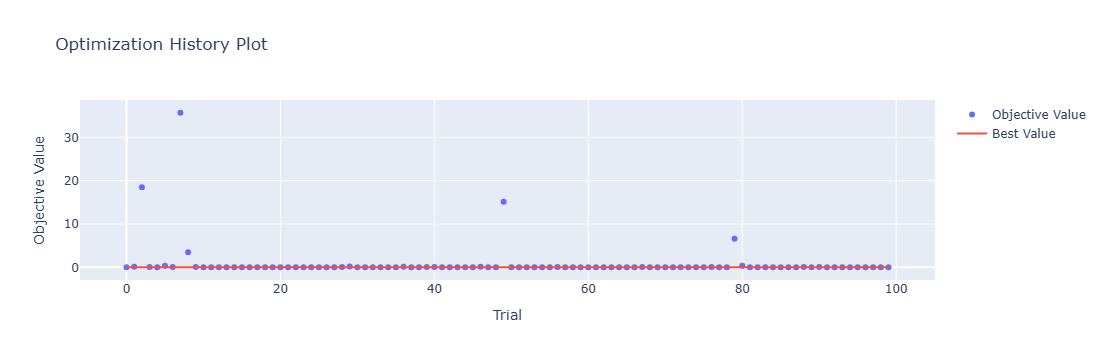

In [4]:
optuna.visualization.plot_optimization_history(study)

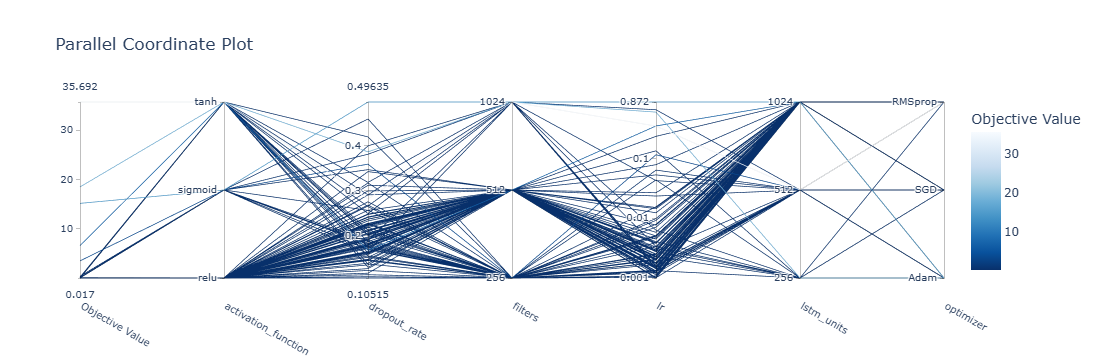

In [5]:
optuna.visualization.plot_parallel_coordinate(study)

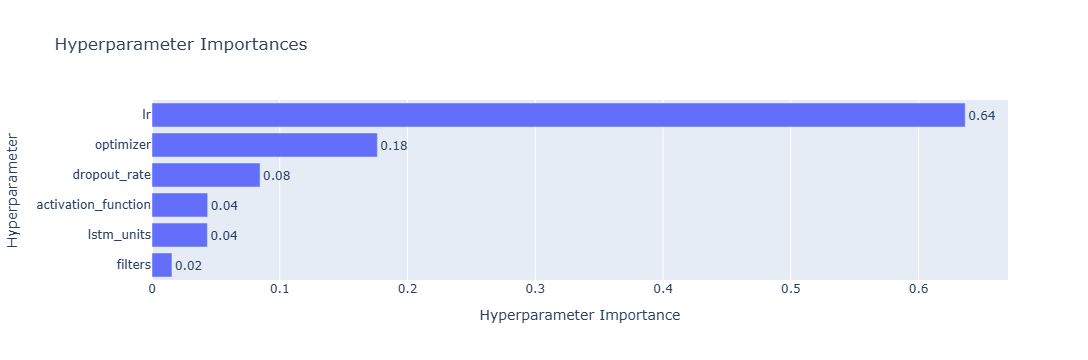

In [6]:
optuna.visualization.plot_param_importances(study)

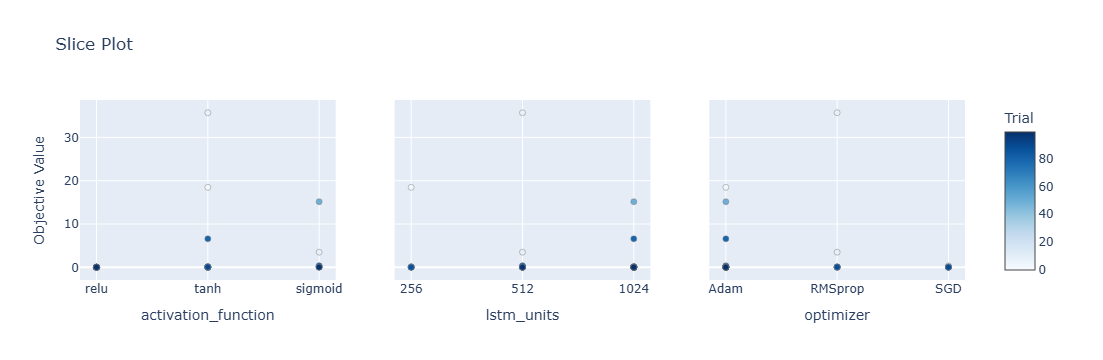

In [7]:
optuna.visualization.plot_slice(study, params=['optimizer', 'activation_function', 'lstm_units'])

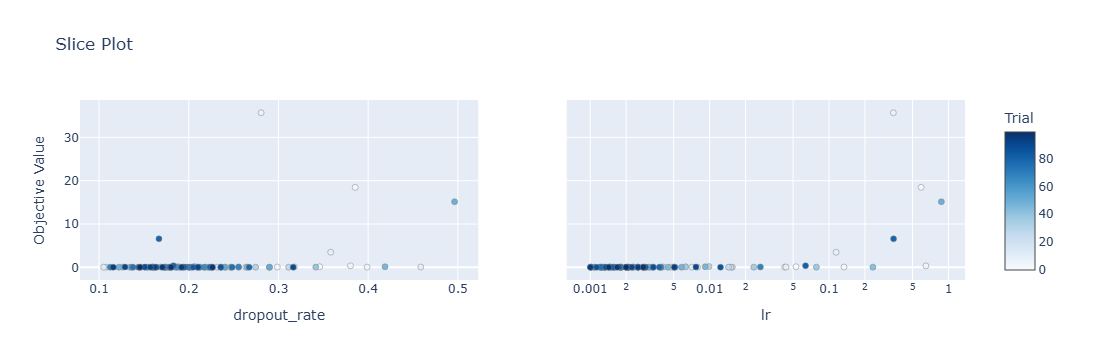

In [8]:
optuna.visualization.plot_slice(study, params=['lr', 'dropout_rate'])

Epoch 1/100
84/84 [==============================] - 43s 254ms/step - loss: 0.1418 - accuracy: 0.0000e+00 - mae: 0.1418 - rmse: 0.1418 - mape: 29.2954 - pearson: nan - val_loss: 0.0450 - val_accuracy: 0.0000e+00 - val_mae: 0.0450 - val_rmse: 0.0450 - val_mape: 9.2508 - val_pearson: nan
Epoch 2/100
84/84 [==============================] - 16s 189ms/step - loss: 0.0780 - accuracy: 0.0000e+00 - mae: 0.0780 - rmse: 0.0780 - mape: 16.4309 - pearson: nan - val_loss: 0.0342 - val_accuracy: 0.0000e+00 - val_mae: 0.0342 - val_rmse: 0.0342 - val_mape: 7.2864 - val_pearson: nan
Epoch 3/100
84/84 [==============================] - 15s 177ms/step - loss: 0.0355 - accuracy: 0.0000e+00 - mae: 0.0355 - rmse: 0.0355 - mape: 7.5627 - pearson: nan - val_loss: 0.0362 - val_accuracy: 0.0000e+00 - val_mae: 0.0362 - val_rmse: 0.0362 - val_mape: 8.2260 - val_pearson: nan
Epoch 10/100
84/84 [==============================] - 14s 166ms/step - loss: 0.0376 - accuracy: 0.0000e+00 - mae: 0.0376 - rmse: 0.0376 - ma

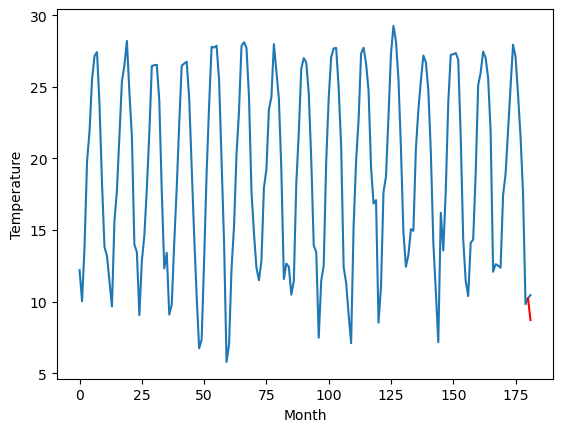

Weather Station 2:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
7.49		7.29		-0.20
[180, 181]
[6.41, 7.2879651212692265]


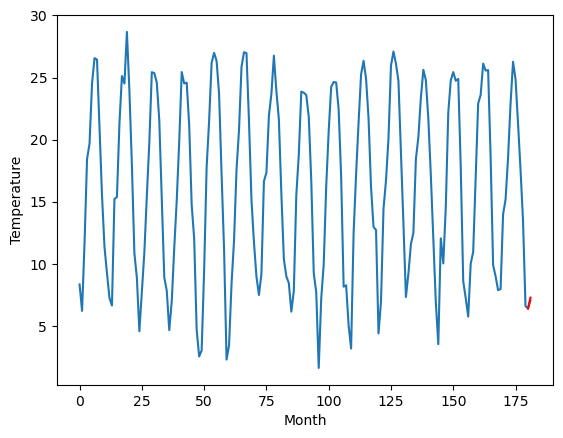

Weather Station 3:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
9.35		8.53		-0.82
[180, 181]
[7.6, 8.527965121269226]


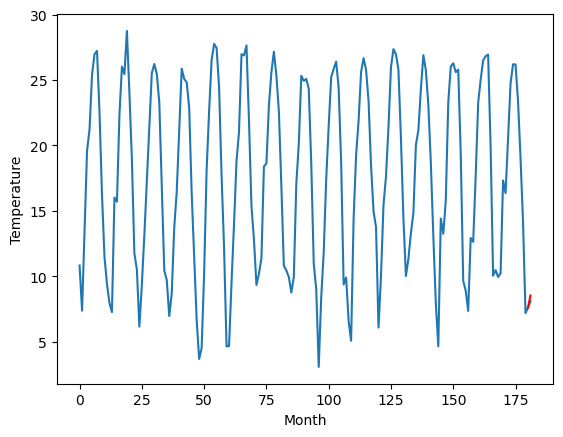

Weather Station 4:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
7.86		7.56		-0.30
[180, 181]
[11.89, 7.557965121269226]


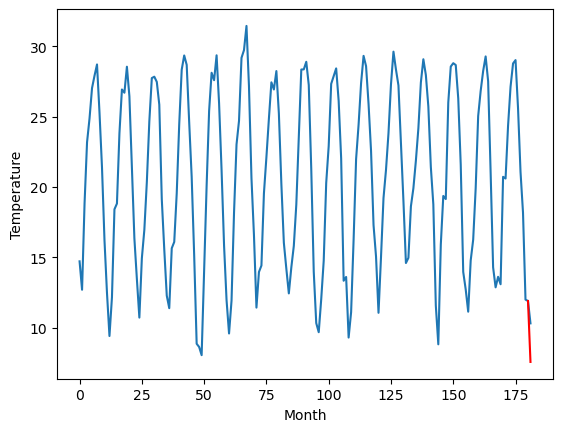

Weather Station 5:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
12.19		11.80		-0.39
[180, 181]
[10.96, 11.797965121269225]


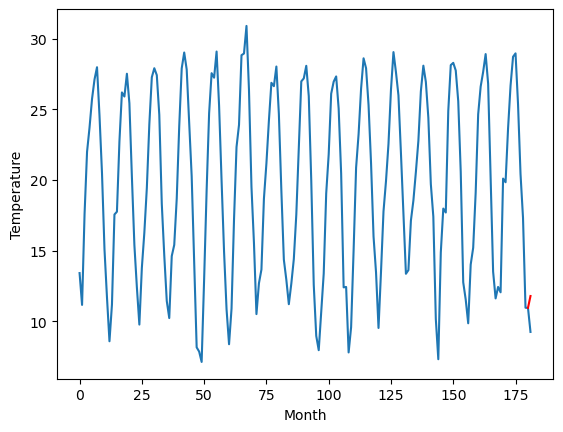

Weather Station 6:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
6.84		7.95		1.11
[180, 181]
[7.75, 7.947965121269226]


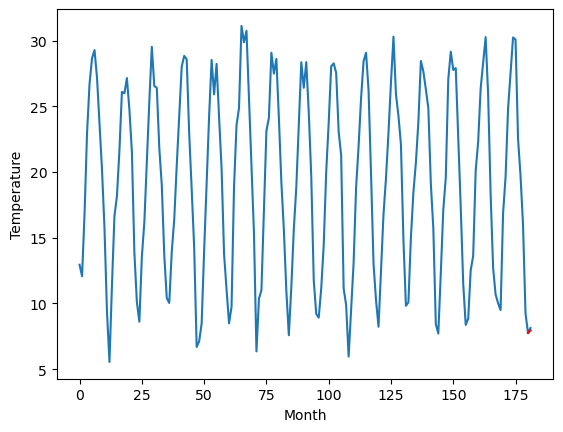

Weather Station 7:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
10.62		10.42		-0.20
[180, 181]
[6.17, 10.417965121269226]


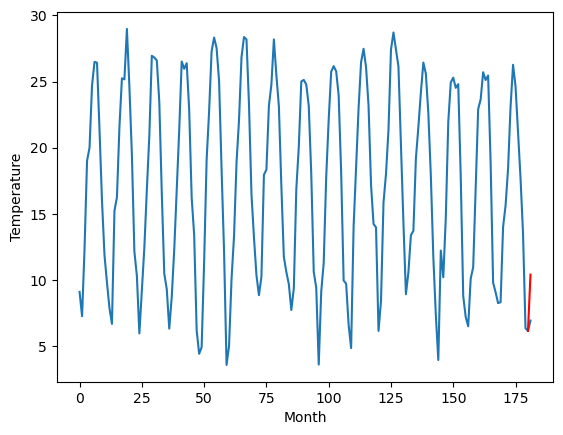

Weather Station 8:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
14.40		14.31		-0.09
[180, 181]
[4.57, 14.307965121269227]


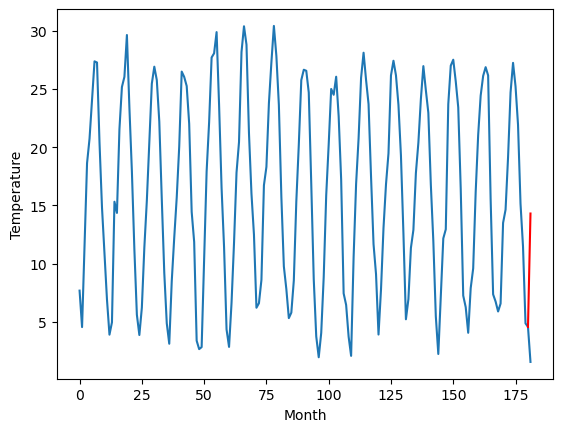

Weather Station 9:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
13.07		13.02		-0.05
[180, 181]
[5.46, 13.017965121269226]


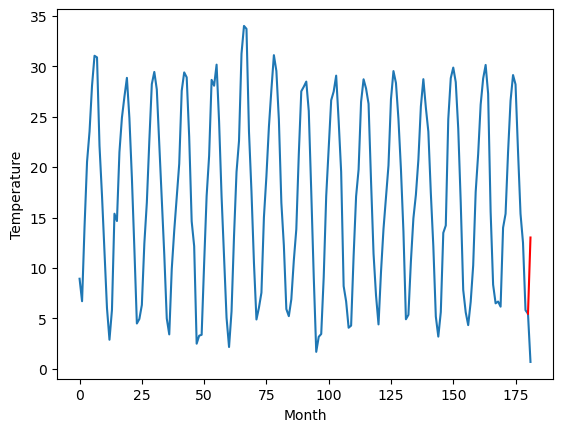

Weather Station 10:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
13.06		12.55		-0.51
[180, 181]
[5.42, 12.547965121269225]


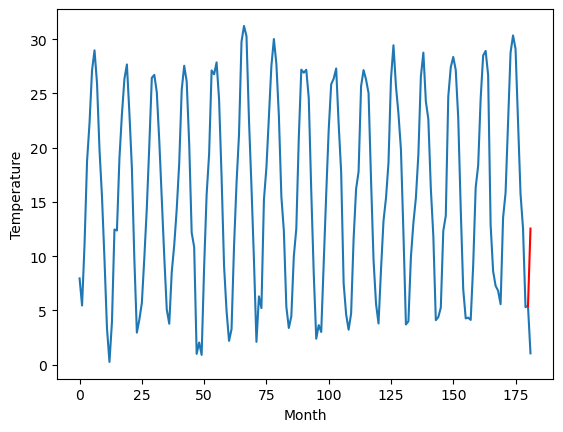

Weather Station 11:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
7.28		8.72		1.44
[180, 181]
[2.17, 8.717965121269225]


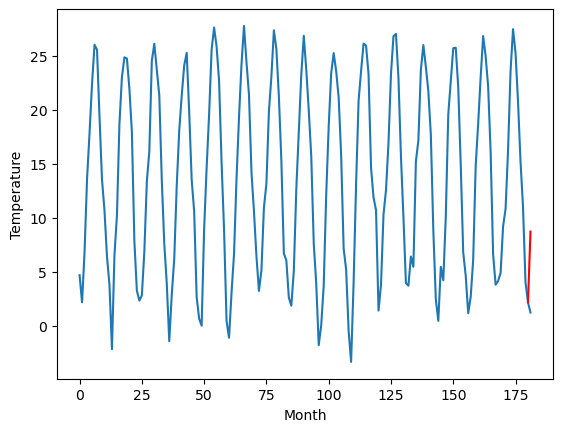

RangeIndex(start=1, stop=12, step=1)
[9.54, 7.489999999999999, 9.35, 7.859999999999999, 12.189999999999998, 6.84, 10.62, 14.4, 13.07, 13.06, 7.279999999999999]
[8.717965121269225, 7.2879651212692265, 8.527965121269226, 7.557965121269226, 11.797965121269225, 7.947965121269226, 10.417965121269226, 14.307965121269227, 13.017965121269226, 12.547965121269225, 8.717965121269225]
Predictions for (t+0):
    Weather_Station  Actual  Predicted
0                 0    9.54   8.717965
1                 1    7.49   7.287965
2                 2    9.35   8.527965
3                 3    7.86   7.557965
4                 4   12.19  11.797965
5                 5    6.84   7.947965
6                 6   10.62  10.417965
7                 7   14.40  14.307965
8                 8   13.07  13.017965
9                 9   13.06  12.547965
10               10    7.28   8.717965


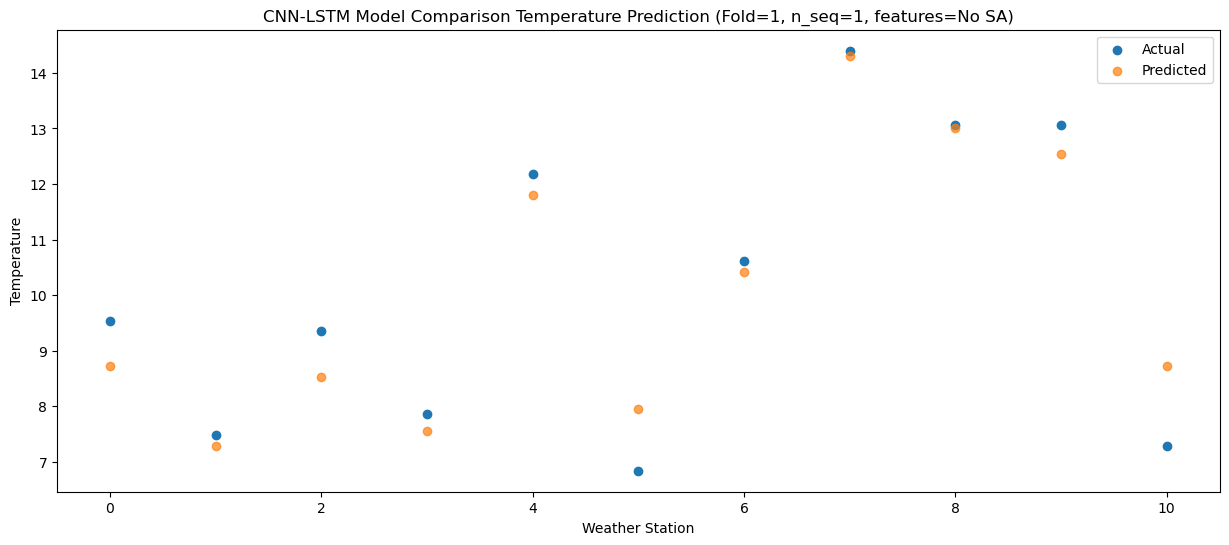

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 1, 512)            1008640   
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 1, 512)           0         
 1D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 1, 512)            0         
                                                                 
 lstm_2 (LSTM)               (None, 1, 512)            2099200   
                                                                 
 dropout_4 (Dropout)         (None, 1, 512)            0         
                                                                 
 lstm_3 (LSTM)               (None, 512)               2099200   
                                                      

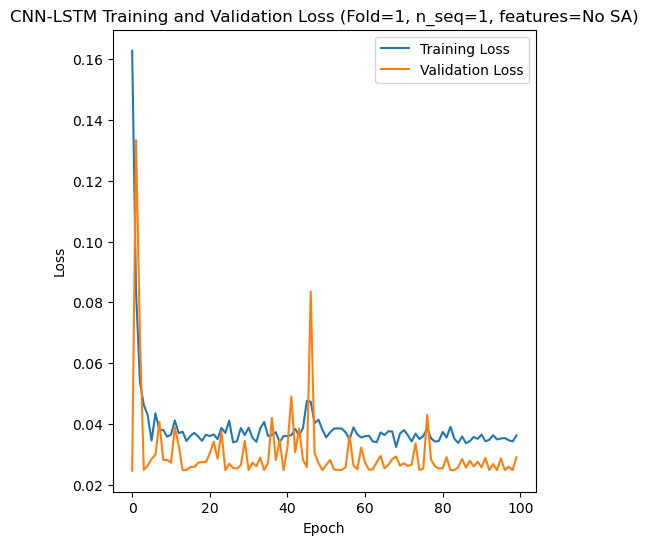

Epoch 1/100
84/84 [==============================] - 39s 199ms/step - loss: 0.1893 - accuracy: 0.0000e+00 - mae: 0.1893 - rmse: 0.1893 - mape: 39.5479 - pearson: nan - val_loss: 0.0409 - val_accuracy: 0.0000e+00 - val_mae: 0.0409 - val_rmse: 0.0409 - val_mape: 9.0166 - val_pearson: nan
Epoch 2/100
84/84 [==============================] - 9s 113ms/step - loss: 0.0686 - accuracy: 0.0000e+00 - mae: 0.0686 - rmse: 0.0686 - mape: 14.4554 - pearson: nan - val_loss: 0.1452 - val_accuracy: 0.0000e+00 - val_mae: 0.1452 - val_rmse: 0.1452 - val_mape: 32.6661 - val_pearson: nan
Epoch 3/100
84/84 [==============================] - 9s 112ms/step - loss: 0.0546 - accuracy: 0.0000e+00 - mae: 0.0546 - rmse: 0.0546 - mape: 11.3667 - pearson: nan - val_loss: 0.0673 - val_accuracy: 0.0000e+00 - val_mae: 0.0673 - val_rmse: 0.0673 - val_mape: 15.2166 - val_pearson: nan
Epoch 4/100
84/84 [==============================] - 10s 116ms/step - loss: 0.0399 - accuracy: 0.0000e+00 - mae: 0.0399 - rmse: 0.0399 - ma

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



84/84 [==============================] - 12s 138ms/step - loss: 0.0344 - accuracy: 0.0000e+00 - mae: 0.0344 - rmse: 0.0344 - mape: 7.2567 - pearson: nan - val_loss: 0.0295 - val_accuracy: 0.0000e+00 - val_mae: 0.0295 - val_rmse: 0.0295 - val_mape: 6.7685 - val_pearson: nan
Epoch 73/100
84/84 [==============================] - 11s 134ms/step - loss: 0.0343 - accuracy: 0.0000e+00 - mae: 0.0343 - rmse: 0.0343 - mape: 7.2181 - pearson: nan - val_loss: 0.0259 - val_accuracy: 0.0000e+00 - val_mae: 0.0259 - val_rmse: 0.0259 - val_mape: 5.9431 - val_pearson: nan
Epoch 74/100
84/84 [==============================] - 11s 135ms/step - loss: 0.0347 - accuracy: 0.0000e+00 - mae: 0.0347 - rmse: 0.0347 - mape: 7.3317 - pearson: nan - val_loss: 0.0144 - val_accuracy: 0.0000e+00 - val_mae: 0.0144 - val_rmse: 0.0144 - val_mape: 3.2917 - val_pearson: nan
Epoch 75/100
84/84 [==============================] - 11s 131ms/step - loss: 0.0366 - accuracy: 0.0000e+00 - mae: 0.0366 - rmse: 0.0366 - mape: 7.6233 -

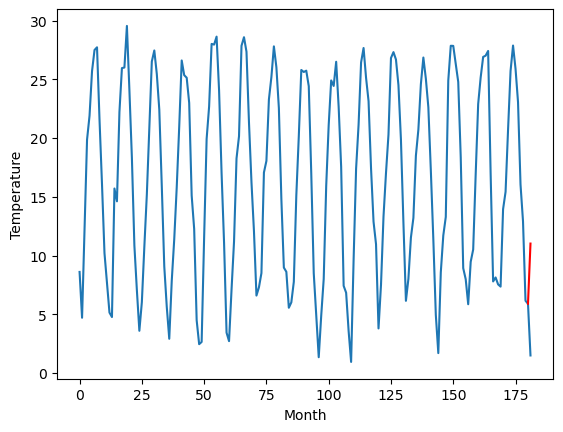

Weather Station 2:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
6.69		5.65		-1.04
[180, 181]
[2.63, 5.65476288318634]


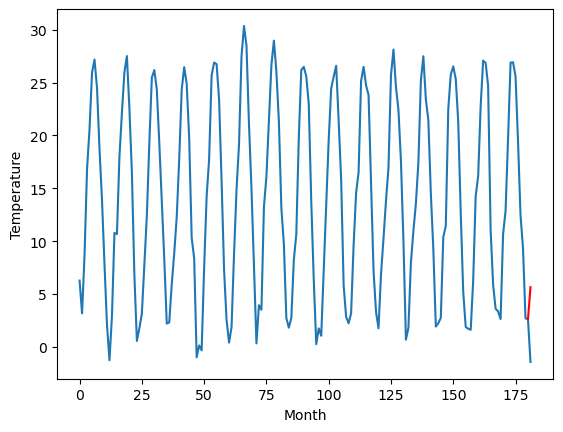

Weather Station 3:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
12.70		10.92		-1.78
[180, 181]
[16.55, 10.924766817092895]


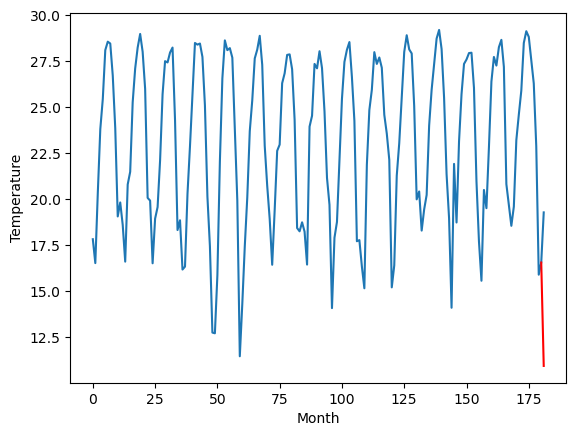

Weather Station 4:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
5.49		7.45		1.96
[180, 181]
[-0.83, 7.454764909744263]


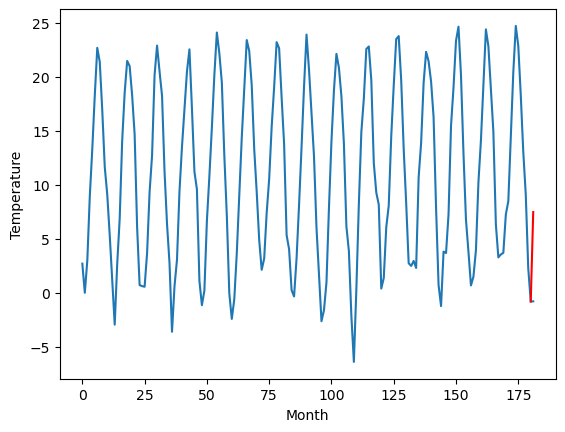

Weather Station 5:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
8.96		7.49		-1.47
[180, 181]
[11.52, 7.494764909744262]


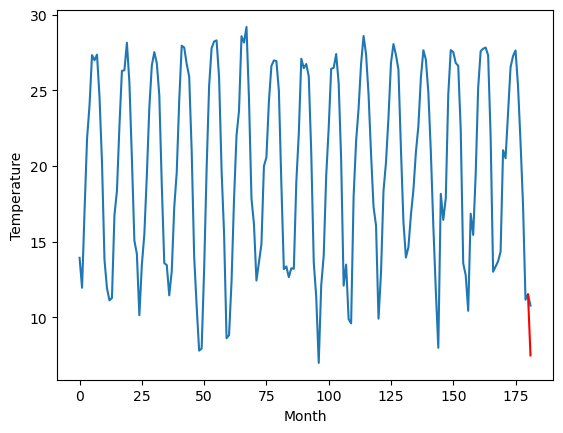

Weather Station 6:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
5.69		5.16		-0.53
[180, 181]
[11.47, 5.164760975837708]


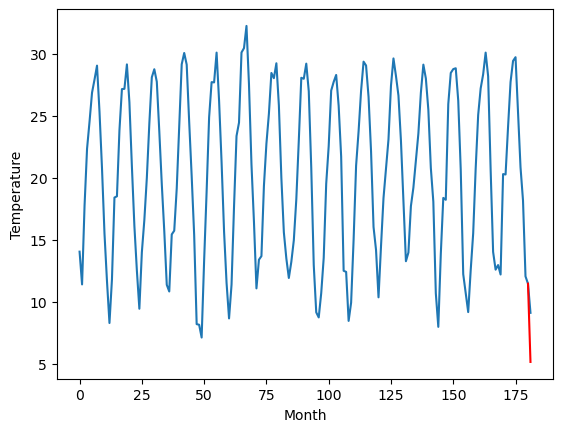

Weather Station 7:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
17.12		16.70		-0.42
[180, 181]
[7.75, 16.704760975837708]


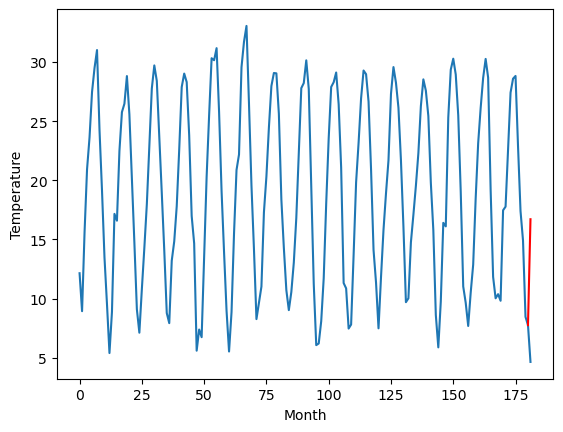

Weather Station 8:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
3.22		1.56		-1.66
[180, 181]
[4.9, 1.5647649097442629]


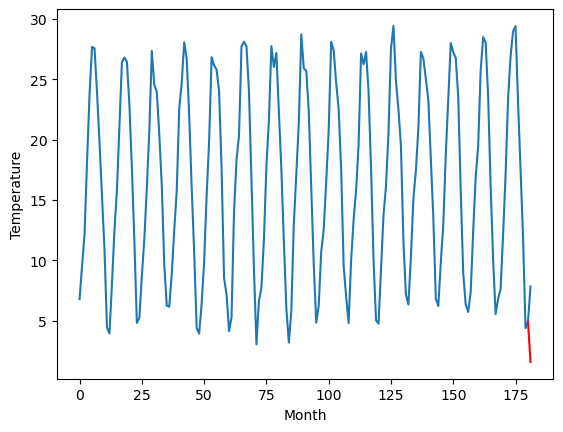

Weather Station 9:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
13.88		12.82		-1.06
[180, 181]
[14.14, 12.824766817092895]


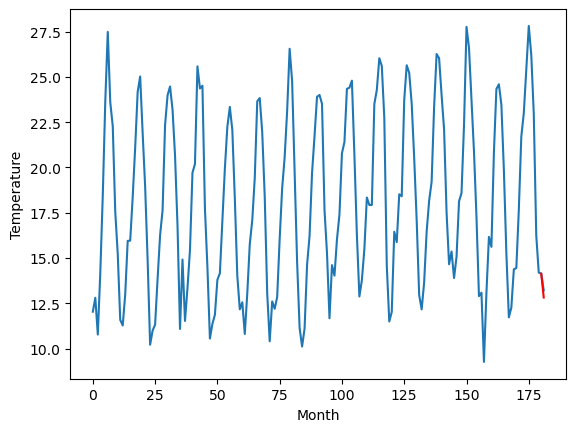

Weather Station 10:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
13.64		12.93		-0.71
[180, 181]
[5.55, 12.934766817092896]


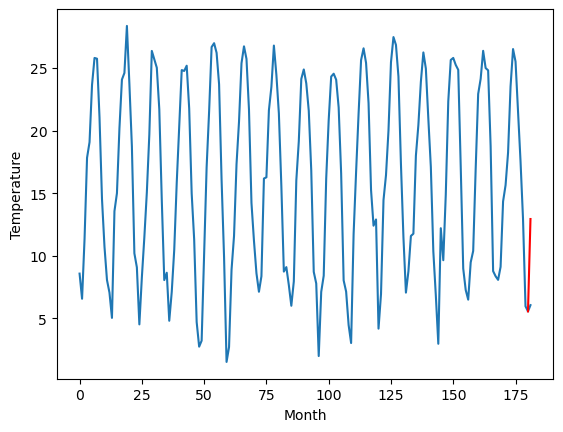

Weather Station 11:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
12.47		11.02		-1.45
[180, 181]
[3.19, 11.024764909744263]


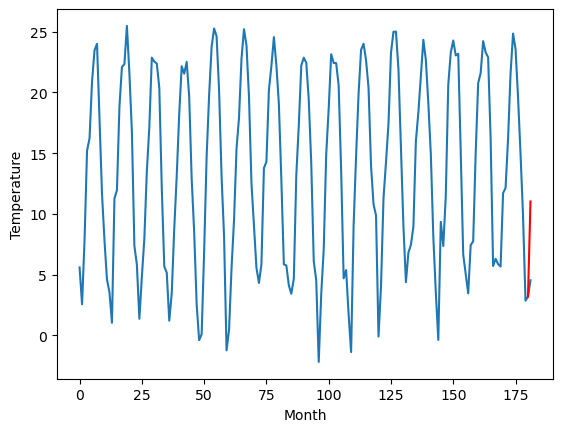

RangeIndex(start=1, stop=12, step=1)
[11.88, 6.69, 12.7, 5.490000000000001, 8.96, 5.69, 17.12, 3.2200000000000015, 13.880000000000003, 13.64, 12.47]
[11.024762883186341, 5.65476288318634, 10.924766817092895, 7.454764909744263, 7.494764909744262, 5.164760975837708, 16.704760975837708, 1.5647649097442629, 12.824766817092895, 12.934766817092896, 11.024764909744263]
Predictions for (t+0):
    Weather_Station  Actual  Predicted
0                 0   11.88  11.024763
1                 1    6.69   5.654763
2                 2   12.70  10.924767
3                 3    5.49   7.454765
4                 4    8.96   7.494765
5                 5    5.69   5.164761
6                 6   17.12  16.704761
7                 7    3.22   1.564765
8                 8   13.88  12.824767
9                 9   13.64  12.934767
10               10   12.47  11.024765


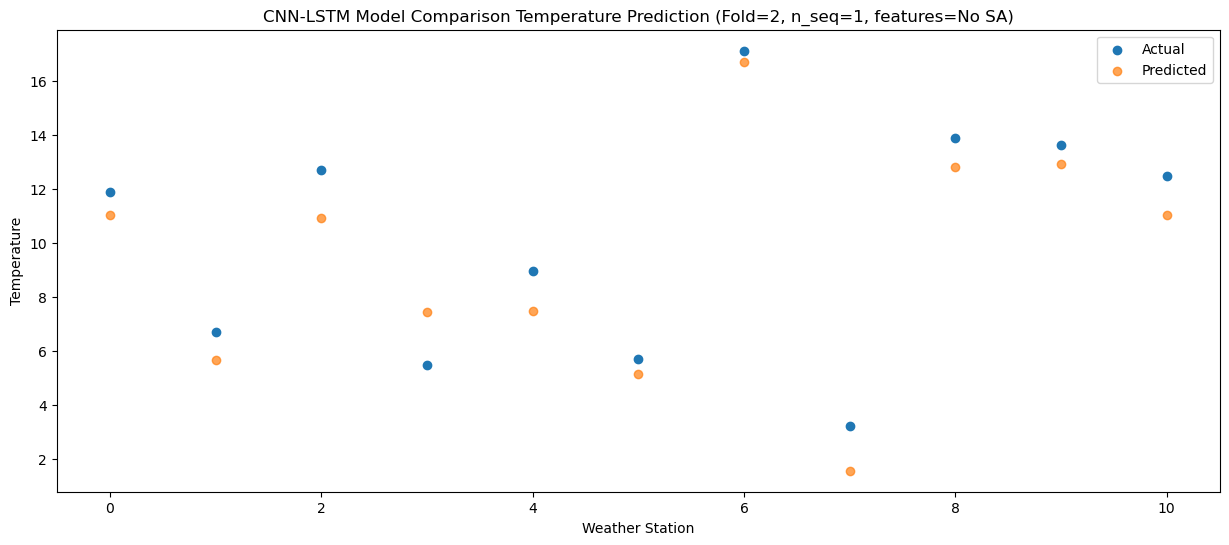

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 1, 512)            1008640   
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 1, 512)           0         
 1D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 1, 512)            0         
                                                                 
 lstm_4 (LSTM)               (None, 1, 512)            2099200   
                                                                 
 dropout_7 (Dropout)         (None, 1, 512)            0         
                                                                 
 lstm_5 (LSTM)               (None, 512)               2099200   
                                                      

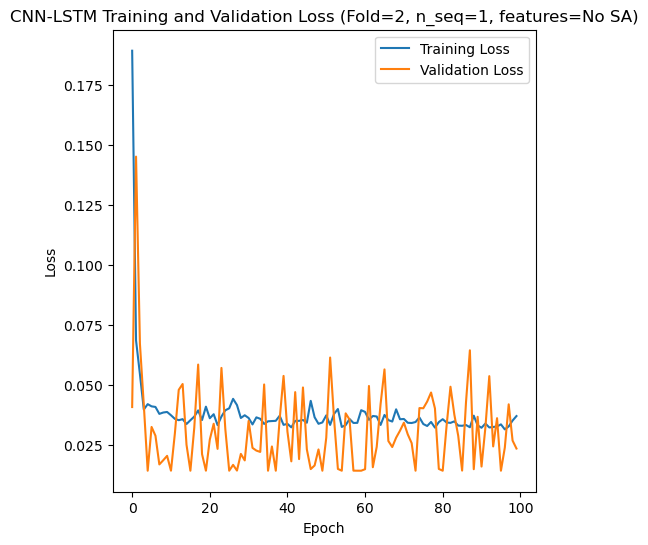

Epoch 1/100
84/84 [==============================] - 39s 195ms/step - loss: 0.1477 - accuracy: 0.0000e+00 - mae: 0.1477 - rmse: 0.1477 - mape: 33.0040 - pearson: nan - val_loss: 0.1168 - val_accuracy: 0.0000e+00 - val_mae: 0.1168 - val_rmse: 0.1168 - val_mape: 26.9593 - val_pearson: nan
Epoch 2/100
84/84 [==============================] - 10s 116ms/step - loss: 0.0670 - accuracy: 0.0000e+00 - mae: 0.0670 - rmse: 0.0670 - mape: 14.9453 - pearson: nan - val_loss: 0.0860 - val_accuracy: 0.0000e+00 - val_mae: 0.0860 - val_rmse: 0.0860 - val_mape: 19.7695 - val_pearson: nan
Epoch 3/100
84/84 [==============================] - 10s 118ms/step - loss: 0.0451 - accuracy: 0.0000e+00 - mae: 0.0451 - rmse: 0.0451 - mape: 10.0400 - pearson: nan - val_loss: 0.0452 - val_accuracy: 0.0000e+00 - val_mae: 0.0452 - val_rmse: 0.0452 - val_mape: 9.7792 - val_pearson: nan
Epoch 4/100
84/84 [==============================] - 10s 119ms/step - loss: 0.0446 - accuracy: 0.0000e+00 - mae: 0.0446 - rmse: 0.0446 - 

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



84/84 [==============================] - 9s 113ms/step - loss: 0.0348 - accuracy: 0.0000e+00 - mae: 0.0348 - rmse: 0.0348 - mape: 7.8442 - pearson: nan - val_loss: 0.0365 - val_accuracy: 0.0000e+00 - val_mae: 0.0365 - val_rmse: 0.0365 - val_mape: 7.2875 - val_pearson: nan
Epoch 93/100
84/84 [==============================] - 9s 112ms/step - loss: 0.0337 - accuracy: 0.0000e+00 - mae: 0.0337 - rmse: 0.0337 - mape: 7.5489 - pearson: nan - val_loss: 0.0369 - val_accuracy: 0.0000e+00 - val_mae: 0.0369 - val_rmse: 0.0369 - val_mape: 7.6079 - val_pearson: nan
Epoch 94/100
84/84 [==============================] - 10s 120ms/step - loss: 0.0343 - accuracy: 0.0000e+00 - mae: 0.0343 - rmse: 0.0343 - mape: 7.7133 - pearson: nan - val_loss: 0.0364 - val_accuracy: 0.0000e+00 - val_mae: 0.0364 - val_rmse: 0.0364 - val_mape: 7.3508 - val_pearson: nan
Epoch 95/100
84/84 [==============================] - 10s 120ms/step - loss: 0.0363 - accuracy: 0.0000e+00 - mae: 0.0363 - rmse: 0.0363 - mape: 8.1508 - p

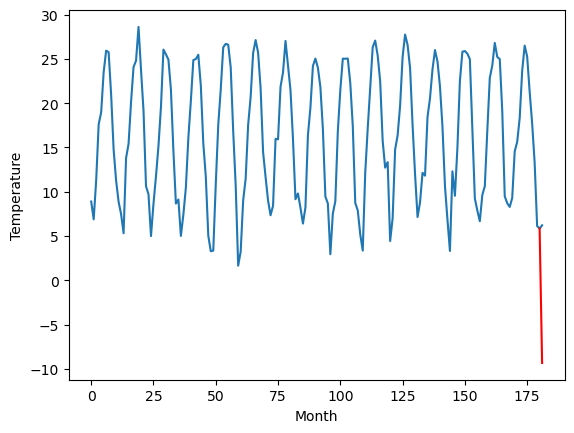

Weather Station 2:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
8.42		8.49		0.07
[180, 181]
[3.2, 8.49191243171692]


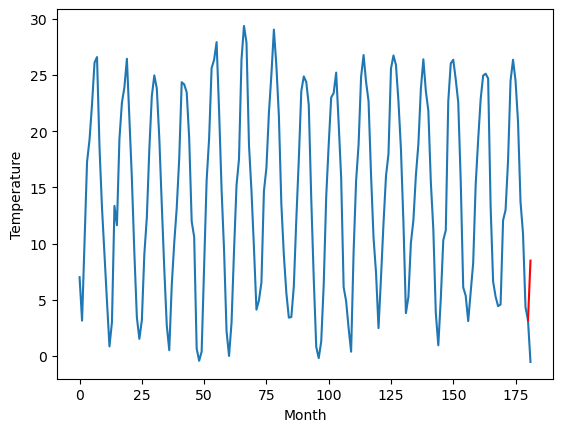

Weather Station 3:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
10.30		7.96		-2.34
[180, 181]
[8.48, 7.961901106834411]


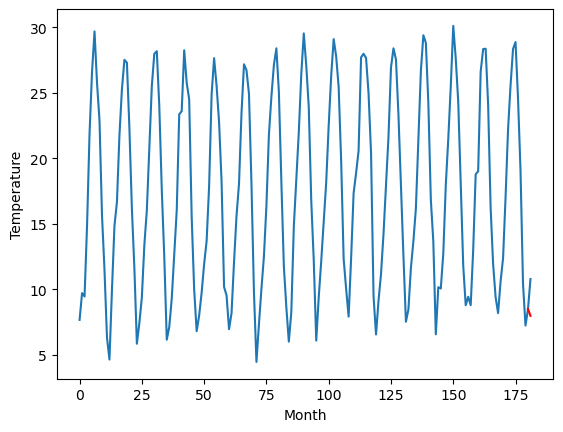

Weather Station 4:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
1.74		2.12		0.38
[180, 181]
[1.55, 2.1219105243682863]


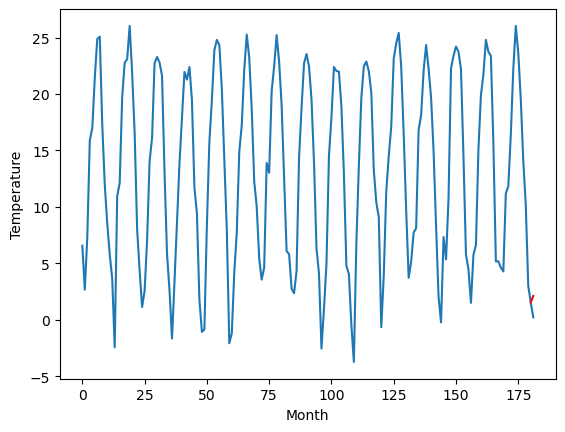

Weather Station 5:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
7.43		7.82		0.39
[180, 181]
[1.08, 7.821903014183045]


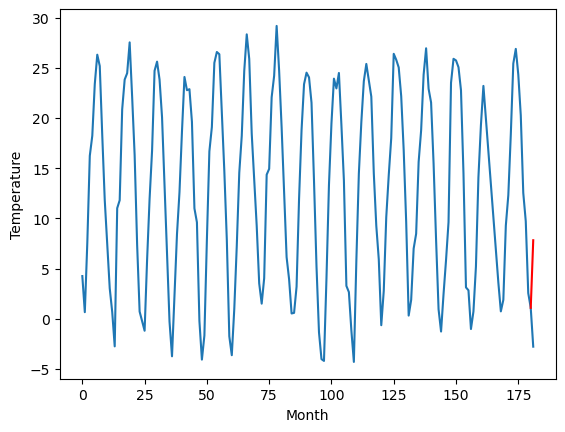

Weather Station 6:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
5.57		5.94		0.37
[180, 181]
[0.21, 5.941904802322387]


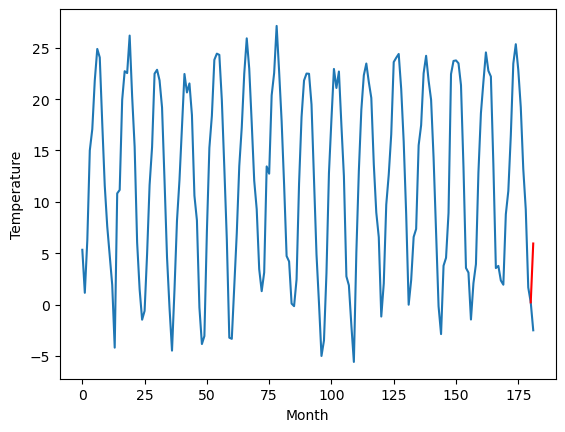

Weather Station 7:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
7.92		6.57		-1.35
[180, 181]
[-8.22, 6.571908617019654]


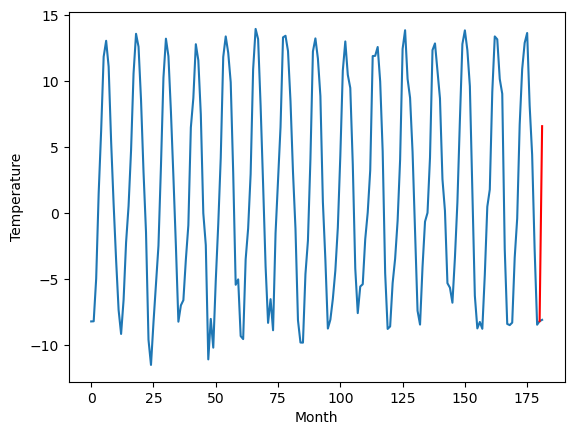

Weather Station 8:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
7.12		5.49		-1.63
[180, 181]
[10.04, 5.491897292137146]


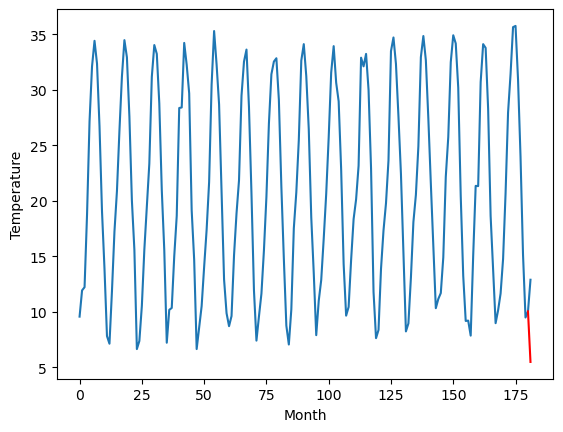

Weather Station 9:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
5.47		3.17		-2.30
[180, 181]
[9.17, 3.1719048023223877]


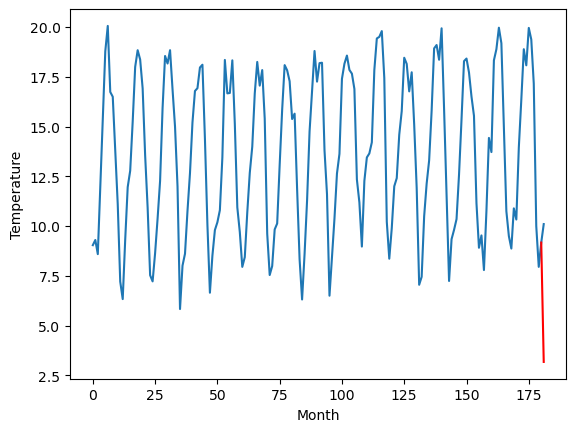

Weather Station 10:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
2.31		4.25		1.94
[180, 181]
[0.94, 4.2519030141830445]


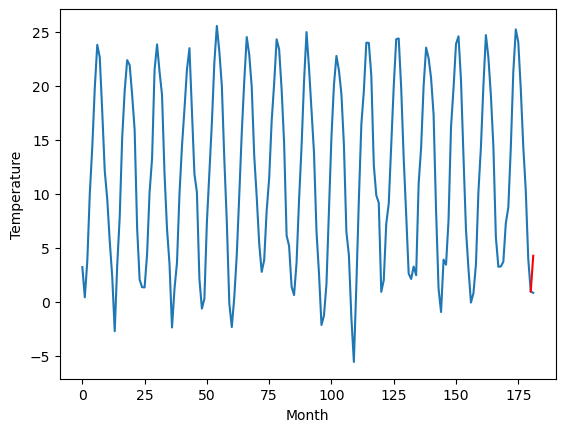

Weather Station 11:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
-9.80		-9.32		0.48
[180, 181]
[-0.13, -9.318098893165589]


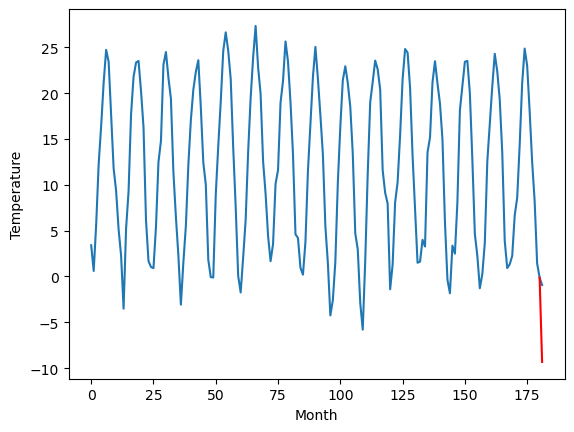

RangeIndex(start=1, stop=12, step=1)
[-8.520000000000001, 8.420000000000002, 10.299999999999999, 1.7399999999999998, 7.430000000000001, 5.5699999999999985, 7.92, 7.119999999999999, 5.4700000000000015, 2.3099999999999996, -9.8]
[-9.31808005809784, 8.49191243171692, 7.961901106834411, 2.1219105243682863, 7.821903014183045, 5.941904802322387, 6.571908617019654, 5.491897292137146, 3.1719048023223877, 4.2519030141830445, -9.318098893165589]
Predictions for (t+0):
    Weather_Station  Actual  Predicted
0                 0   -8.52  -9.318080
1                 1    8.42   8.491912
2                 2   10.30   7.961901
3                 3    1.74   2.121911
4                 4    7.43   7.821903
5                 5    5.57   5.941905
6                 6    7.92   6.571909
7                 7    7.12   5.491897
8                 8    5.47   3.171905
9                 9    2.31   4.251903
10               10   -9.80  -9.318099


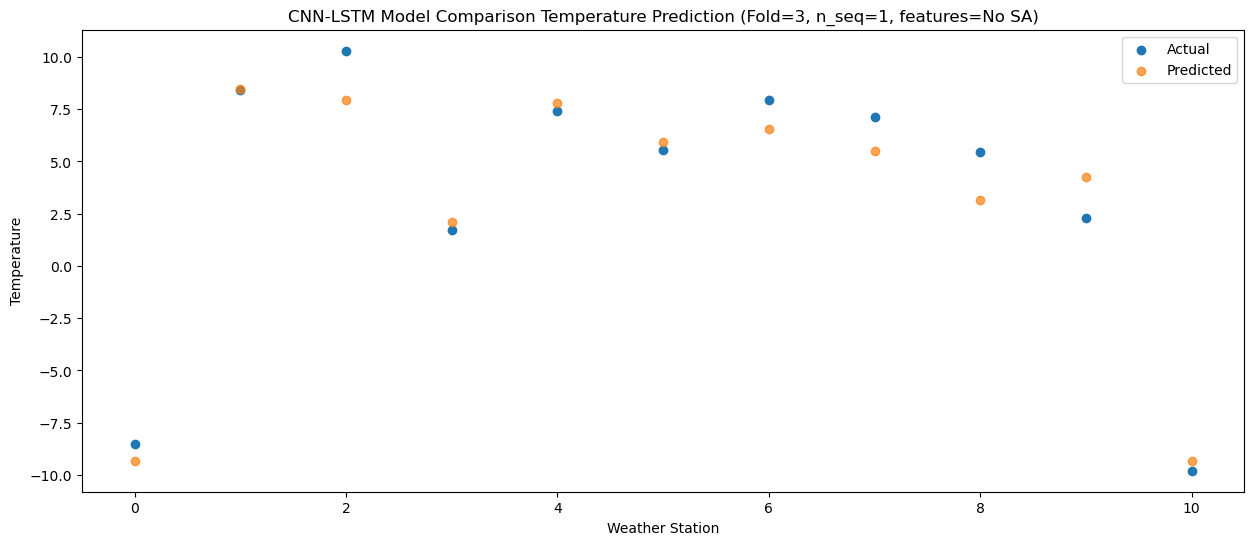

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, 1, 512)            1008640   
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 1, 512)           0         
 1D)                                                             
                                                                 
 dropout_9 (Dropout)         (None, 1, 512)            0         
                                                                 
 lstm_6 (LSTM)               (None, 1, 512)            2099200   
                                                                 
 dropout_10 (Dropout)        (None, 1, 512)            0         
                                                                 
 lstm_7 (LSTM)               (None, 512)               2099200   
                                                      

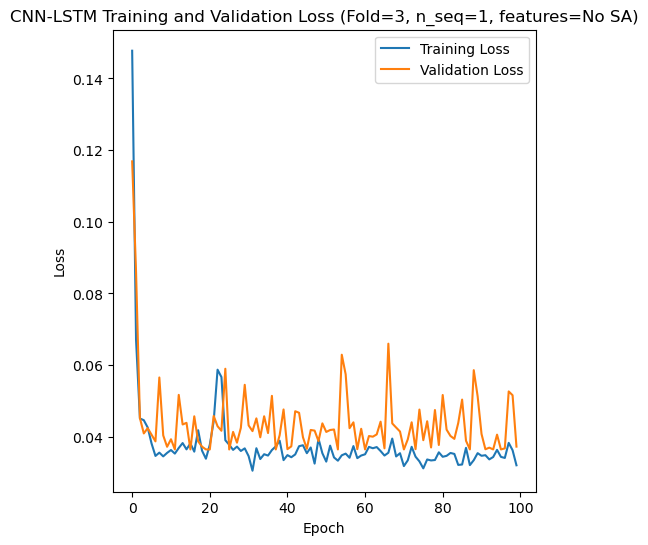

Epoch 1/100
84/84 [==============================] - 38s 210ms/step - loss: 0.1729 - accuracy: 0.0000e+00 - mae: 0.1729 - rmse: 0.1729 - mape: 36.3580 - pearson: nan - val_loss: 0.1365 - val_accuracy: 0.0000e+00 - val_mae: 0.1365 - val_rmse: 0.1365 - val_mape: 27.8262 - val_pearson: nan
Epoch 2/100
84/84 [==============================] - 10s 118ms/step - loss: 0.0755 - accuracy: 0.0000e+00 - mae: 0.0755 - rmse: 0.0755 - mape: 15.7762 - pearson: nan - val_loss: 0.0483 - val_accuracy: 0.0000e+00 - val_mae: 0.0483 - val_rmse: 0.0483 - val_mape: 10.2816 - val_pearson: nan
Epoch 3/100
84/84 [==============================] - 10s 120ms/step - loss: 0.0486 - accuracy: 0.0000e+00 - mae: 0.0486 - rmse: 0.0486 - mape: 10.1892 - pearson: nan - val_loss: 0.0733 - val_accuracy: 0.0000e+00 - val_mae: 0.0733 - val_rmse: 0.0733 - val_mape: 17.3782 - val_pearson: nan
Epoch 4/100
84/84 [==============================] - 10s 121ms/step - loss: 0.0406 - accuracy: 0.0000e+00 - mae: 0.0406 - rmse: 0.0406 -

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



84/84 [==============================] - 11s 128ms/step - loss: 0.0321 - accuracy: 0.0000e+00 - mae: 0.0321 - rmse: 0.0321 - mape: 6.8260 - pearson: nan - val_loss: 0.0480 - val_accuracy: 0.0000e+00 - val_mae: 0.0480 - val_rmse: 0.0480 - val_mape: 10.3851 - val_pearson: nan
Epoch 58/100
84/84 [==============================] - 11s 129ms/step - loss: 0.0330 - accuracy: 0.0000e+00 - mae: 0.0330 - rmse: 0.0330 - mape: 6.8939 - pearson: nan - val_loss: 0.0561 - val_accuracy: 0.0000e+00 - val_mae: 0.0561 - val_rmse: 0.0561 - val_mape: 12.7821 - val_pearson: nan
Epoch 59/100
84/84 [==============================] - 10s 114ms/step - loss: 0.0404 - accuracy: 0.0000e+00 - mae: 0.0404 - rmse: 0.0404 - mape: 8.4681 - pearson: nan - val_loss: 0.0480 - val_accuracy: 0.0000e+00 - val_mae: 0.0480 - val_rmse: 0.0480 - val_mape: 10.3607 - val_pearson: nan
Epoch 60/100
84/84 [==============================] - 9s 110ms/step - loss: 0.0387 - accuracy: 0.0000e+00 - mae: 0.0387 - rmse: 0.0387 - mape: 8.0930

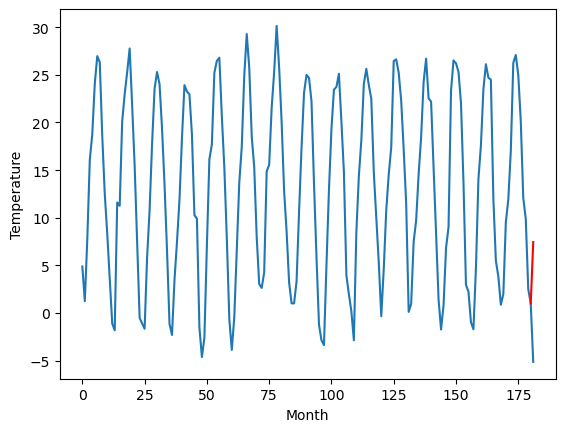

Weather Station 2:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
8.34		5.78		-2.56
[180, 181]
[14.25, 5.780091180801391]


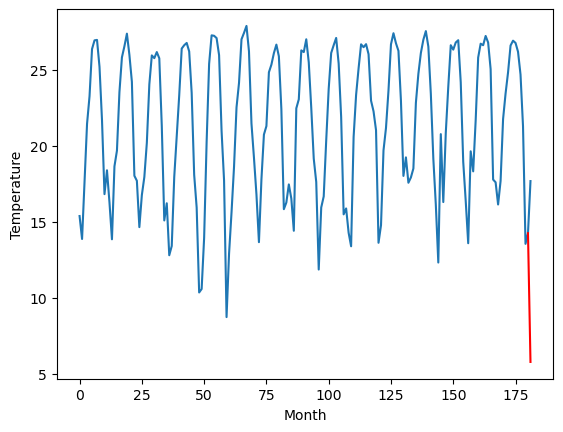

Weather Station 3:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
4.29		2.40		-1.89
[180, 181]
[9.06, 2.4000911808013914]


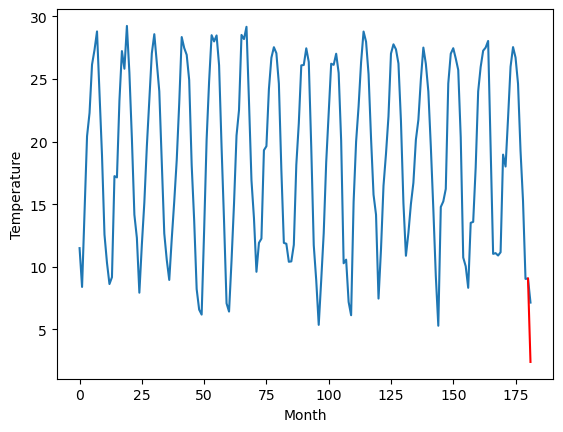

Weather Station 4:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
2.70		1.76		-0.94
[180, 181]
[7.48, 1.7600911808013917]


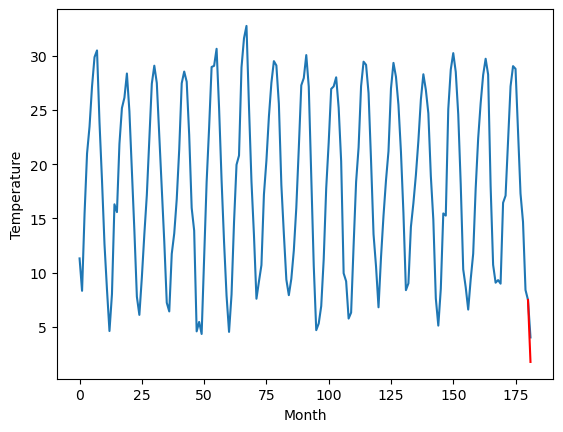

Weather Station 5:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
4.29		3.03		-1.26
[180, 181]
[7.33, 3.0300911808013913]


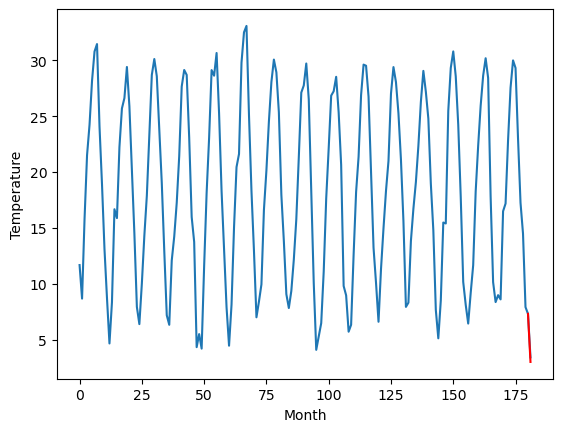

Weather Station 6:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
14.28		13.52		-0.76
[180, 181]
[6.59, 13.520091180801392]


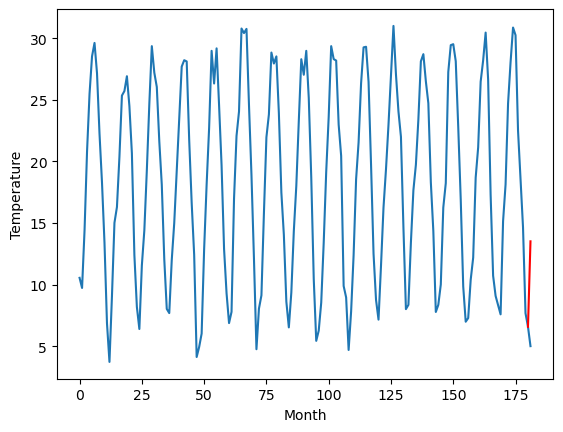

Weather Station 7:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
11.72		9.63		-2.09
[180, 181]
[6.04, 9.630091180801392]


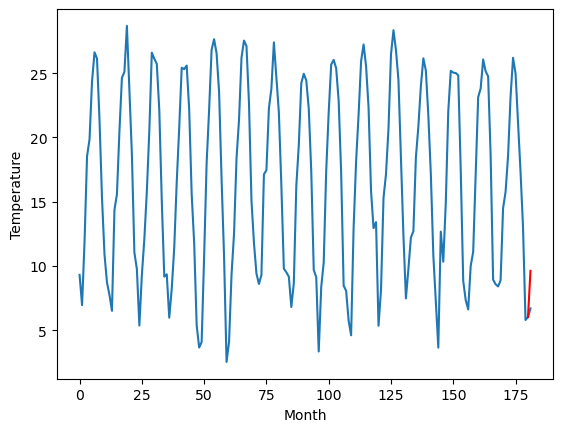

Weather Station 8:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
9.64		9.45		-0.19
[180, 181]
[3.13, 9.450091180801392]


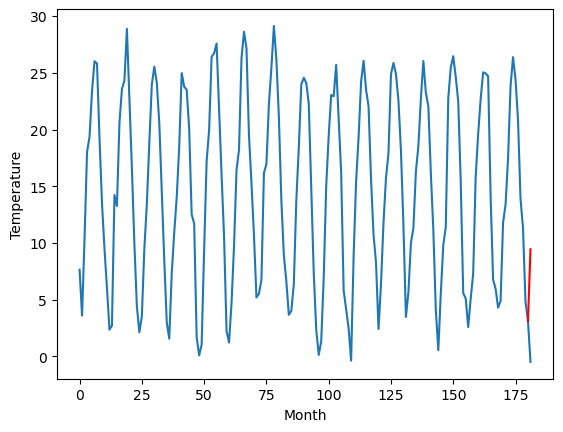

Weather Station 9:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
10.11		9.83		-0.28
[180, 181]
[-0.29, 9.830091180801391]


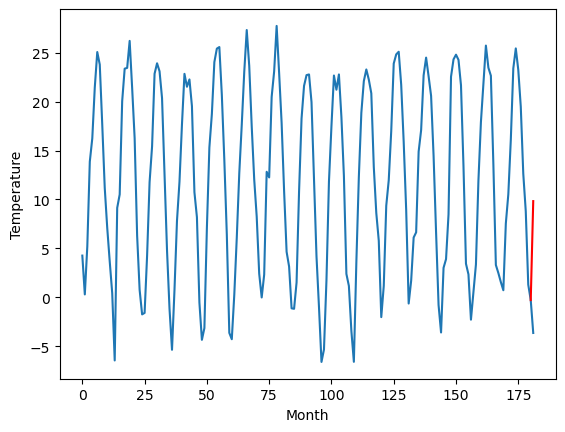

Weather Station 10:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
8.53		8.70		0.17
[180, 181]
[-1.03, 8.700091180801392]


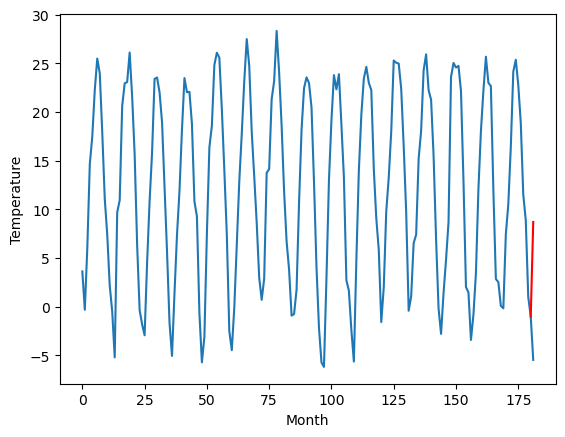

Weather Station 11:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
7.40		7.46		0.06
[180, 181]
[-2.29, 7.460091180801392]


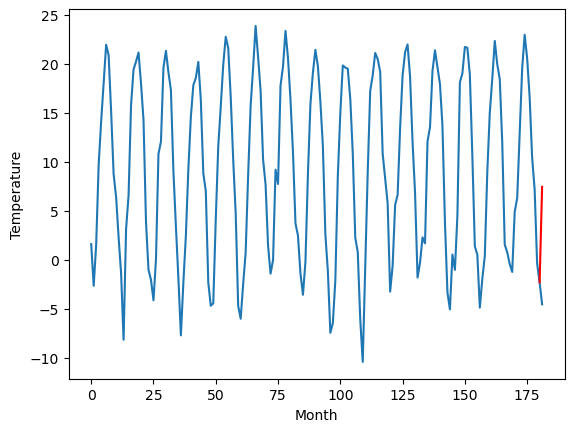

RangeIndex(start=1, stop=12, step=1)
[7.810000000000001, 8.339999999999998, 4.290000000000002, 2.7000000000000006, 4.289999999999999, 14.280000000000001, 11.719999999999999, 9.64, 10.11, 8.53, 7.4]
[7.460091180801392, 5.780091180801391, 2.4000911808013914, 1.7600911808013917, 3.0300911808013913, 13.520091180801392, 9.630091180801392, 9.450091180801392, 9.830091180801391, 8.700091180801392, 7.460091180801392]
Predictions for (t+0):
    Weather_Station  Actual  Predicted
0                 0    7.81   7.460091
1                 1    8.34   5.780091
2                 2    4.29   2.400091
3                 3    2.70   1.760091
4                 4    4.29   3.030091
5                 5   14.28  13.520091
6                 6   11.72   9.630091
7                 7    9.64   9.450091
8                 8   10.11   9.830091
9                 9    8.53   8.700091
10               10    7.40   7.460091


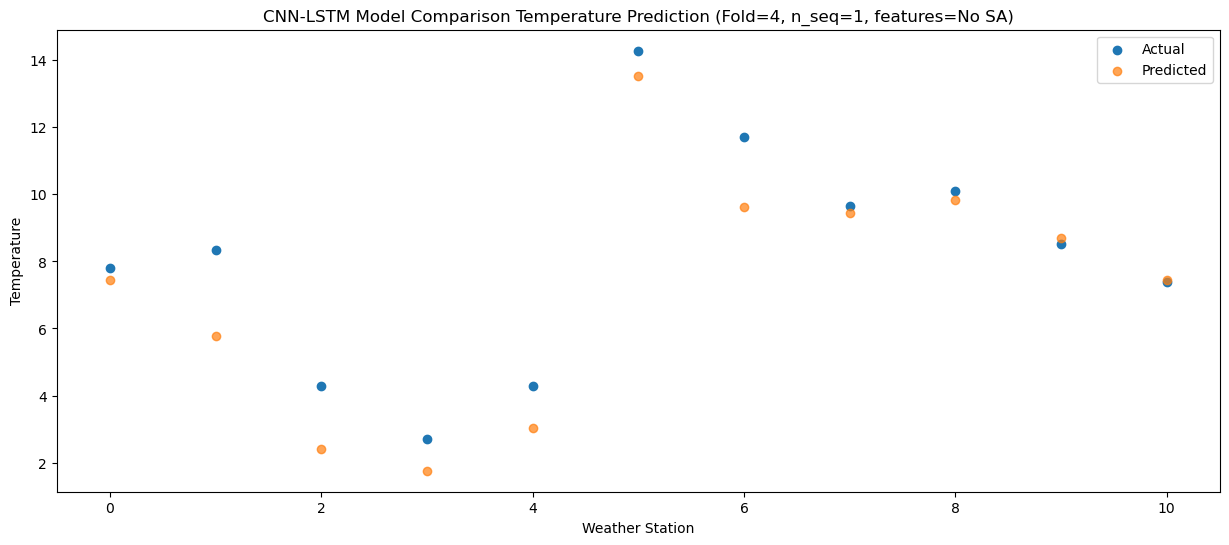

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 1, 512)            1008640   
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 1, 512)           0         
 1D)                                                             
                                                                 
 dropout_12 (Dropout)        (None, 1, 512)            0         
                                                                 
 lstm_8 (LSTM)               (None, 1, 512)            2099200   
                                                                 
 dropout_13 (Dropout)        (None, 1, 512)            0         
                                                                 
 lstm_9 (LSTM)               (None, 512)               2099200   
                                                      

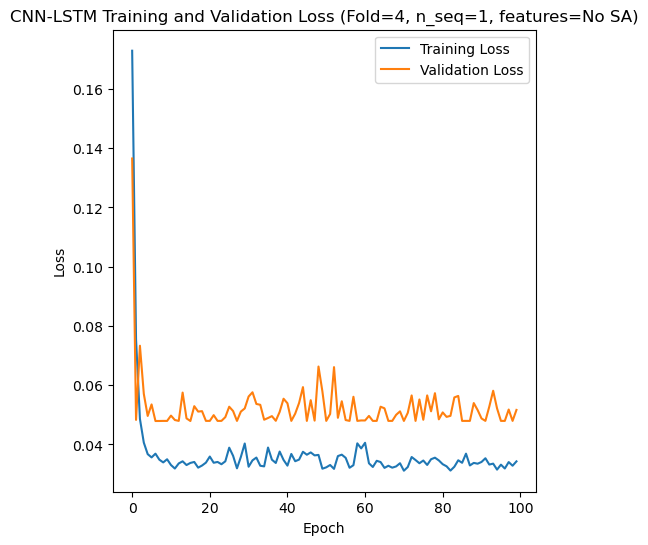

[[0.8547053796007404], [0.6906336646837138], [1.273845015204333], [1.3584447239865909], [1.2724443214424046]]
[[0.6370891048691495], [0.5403858319195831], [1.1724656373804272], [1.095627557581121], [0.9590328849445691]]
[[0.08059357422159436], [0.06361411650322092], [0.1601967981514729], [0.21609518476482295], [0.15827870339835204]]
[[0.8831850536041133], [0.9270924608919384], [0.9073094377707518], [0.9551456270950986], [0.847406841572828]]
[[[7.998028194904327], [7.018022294044495], [5.638018419742584], [4.438031175136566], [11.358034095764161], [13.668016452789306], [8.058021340370178], [13.378012518882752], [12.448015439510346], [9.937999763488769], [7.997997796535492]], [[8.717965121269225], [7.2879651212692265], [8.527965121269226], [7.557965121269226], [11.797965121269225], [7.947965121269226], [10.417965121269226], [14.307965121269227], [13.017965121269226], [12.547965121269225], [8.717965121269225]], [[11.024762883186341], [5.65476288318634], [10.924766817092895], [7.4547649097

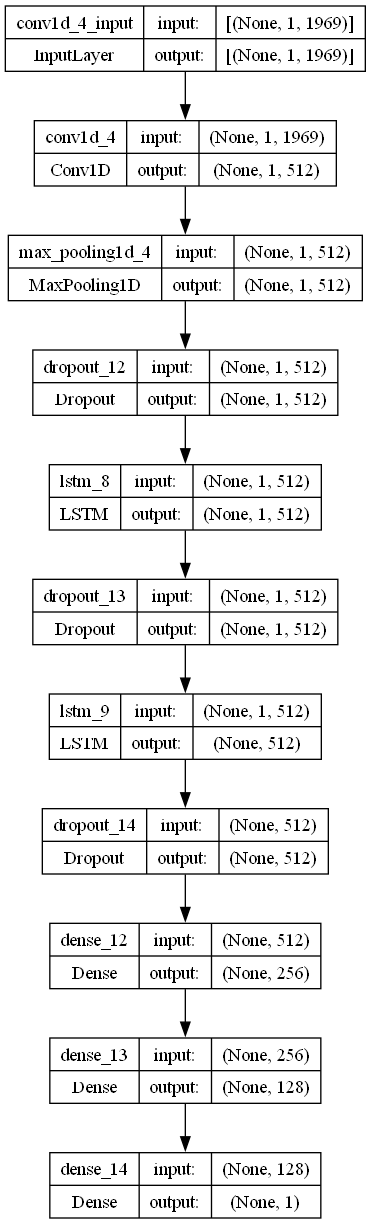

In [3]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from tensorflow.keras.utils import plot_model

def rmse (y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

# fit the best LSTM model using parameters found by Optuna
def create_best_model(X, y, n_lag, n_seq, n_batch, nb_epoch):
    
    #Parameters:
    #trial (array-like): Optuna parameters.
    #train (array-like): Target values.
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations
    #nb_epoch (int): Maximum number of epochs
    
    # Hyperparameters from the best model
    filters = 512
    lr = 0.001289731166834595
    optimizer = Adam(learning_rate = lr)
    activation_function = 'tanh'
    lstm_units = 512
    dropout_rate = 0.20008098662471505

    # design network
    model = Sequential()
    model.add(Conv1D(filters=filters, kernel_size=1, activation='relu', input_shape=(X.shape[1], X.shape[2]))) # CNN-LSTM only
    model.add(MaxPooling1D(pool_size=1)) # CNN-LSTM only
    model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm_units, return_sequences=True))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm_units))
    model.add(Dropout(dropout_rate))
    model.add(Dense(256, input_dim=y.shape[1], activation=activation_function))
    model.add(Dense(128, activation=activation_function))
    model.add(Dense(n_seq))
    model.compile(loss=rmse, optimizer=optimizer, metrics=['accuracy', 'mae', rmse, mape, pearson])
        
    return model

# make one forecast with a CNN-LSTM model,
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def forecast_cnnlstm(model, X, n_seq, n_test):
    # reshape input pattern to [samples, timesteps, features]
    X = X.reshape(1, 1, X.shape[1])
    # make forecast
    forecast = model.predict(X)
    # convert to array
    return forecast
     
# evaluate the persistence model
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def make_forecasts(model, X_test, y_test, n_lag, n_seq, n_test):
    forecasts = list()
    for i in range(len(X_test)):
        X, y = X_test[i, :], y_test[i, :]
        # make forecast
        forecast = forecast_cnnlstm(model, X, n_seq, n_test)
        # store the forecast
        forecasts.append(forecast)
    return forecasts
     
# invert differenced forecast
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def inverse_difference(last_ob, forecast):
    # invert first forecast
    inverted = list()
    inverted.append(forecast[0] + last_ob)
    # propagate difference forecast using inverted first value
    for i in range(1, len(forecast)):
        inverted.append(forecast[i] + inverted[i-1])
    return inverted
     
# inverse data transform on forecasts
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def inverse_transform(series, forecasts, scaler, n_test, n_seq):
    inverted = list()
    for i in range(len(forecasts)):
        # create array from forecast
        forecast = forecasts[i]
        forecast = forecast.reshape(1, n_seq)
        # invert scaling
        inv_scale = scaler.inverse_transform(forecast)
        inv_scale = inv_scale[0, :]
        # invert differencing
        index = len(series) - n_test + i - 1
        last_ob = series.values[index]
        inv_diff = inverse_difference(last_ob, inv_scale)
        # store
        inverted.append(inv_diff)
    return inverted
     
# evaluate the RMSE for each forecast time step
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def evaluate_forecasts(test, forecasts, n_lag, n_seq):
    rmse_list = []
    mae_list = []
    mape_list = []
    r2_list = []
    for i in range(n_seq):
        actual = [row[i] for row in test]
        predicted = [forecast[i] for forecast in forecasts]
        rmse = sqrt(mean_squared_error(actual, predicted))
        mae = mean_absolute_error(actual, predicted)
        mse = mean_squared_error(actual, predicted)
        mape = mean_absolute_percentage_error(actual, predicted)
        r2 = r2_score(actual, predicted) 
        rmse_list.append(rmse)
        mae_list.append(mae)
        mape_list.append(mape)
        r2_list.append(r2)
        print("Month at t+"+str(i+1)+":")
        print('t+%d RMSE: %f' % ((i+1), rmse))
        print('t+%d MAE: %f' % ((i+1), mae))
        print('t+%d MAPE: %f' % ((i+1), mape))
        print('t+%d R2_SCORE: %f' % ((i+1), r2))

    return rmse_list, mae_list, mape_list, r2_list
     
# plot the forecasts in the context of the original dataset
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def plot_forecasts(series, forecasts, n_test, n_seq, n_lag):
    # plot the entire dataset in blue
    plt.plot(series[:n_lag+2+len(forecasts)].values)
    # plot the forecasts in red
    off_s = n_lag + 1
    off_e = off_s + len(forecasts) + 1
    xaxis = [x for x in range(off_s, off_e)]
    yaxis = [series.values[off_s]] + forecasts
    print(xaxis)
    print(yaxis)
    plt.plot(xaxis, yaxis, color='red')
    plt.xlabel("Month")
    plt.ylabel("Temperature")
    # show the plot
    plt.show()

n_batch = 1
n_test = 11
nb_epoch = 100
    
rmse_avg_list = []
mae_avg_list = []
mape_avg_list = []
r2_score_avg_list = []
forecast_results = []
actual_results = []
    
for i in range(5):
    train1 = train[i]
    test1 = test[i]
    validation1 = validation[i]

    X = train1[:, 0:-n_seq]
    y = train1[:, -n_seq:]
    X_test = test1[:, 0:-n_seq]
    y_test = test1[:, -n_seq:]
    X_val = validation1[:, 0:-n_seq]
    y_val = validation1[:, -n_seq:]

    dataset_df = pd.DataFrame(val_y[i])
    dataset_df = dataset_df.iloc[0:10, :]
    dataset = dataset_df.values

    series = pd.Series(dataset[:, 0]) # Using first column (temperatures)

    X = X.reshape(X.shape[0], 1, X.shape[1])
    X1 = X_test
    X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
    X_val = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])

    best_model = create_best_model(X, y, n_lag, n_seq, n_batch, nb_epoch)
    history = best_model.fit(X, y, epochs=100, batch_size=n_batch, validation_data=(X_val, y_val))

    # Evaluate the model
    loss = best_model.evaluate(X_test, y_test, verbose=2)
    print(f'Test Loss: {loss}')

    # make forecasts
    forecasts = make_forecasts(best_model, X_test, y_test, n_lag, n_seq, n_test)
    
    # inverse transform forecasts and test
    forecasts = inverse_transform(series, forecasts, scaler[i], n_test+2, n_seq)
    actual = [row[-n_seq:] for row in test1]
    actual = inverse_transform(series, actual, scaler[i], n_test+2, n_seq)

    rmse_list = [] # list stores root mean squared errors for each future time prediction
    mae_list = [] # list stores root mean squared errors for each future time prediction
    mape_list = [] # list stores root mean squared errors for each future time prediction
    r2_list = [] # list stores root mean squared errors for each future time prediction

    # evaluate forecasts
    rmse_list, mae_list, mape_list, r2_list = evaluate_forecasts(actual, forecasts, n_lag, n_seq)

    rmse_avg_list.append(rmse_list)
    mae_avg_list.append(mae_list)
    mape_avg_list.append(mape_list)
    r2_score_avg_list.append(r2_list)
    forecast_results.append(forecasts)
    actual_results.append(actual)

    for j in range(11):
        print("Weather Station "+str(j+1)+":")
        print("Actual Temp\tPredicted Temp\tDifference")
        print("-----------\t--------------\t----------")
        for k in range(n_seq):
            diff = forecasts[j][k] - actual[j][k]
            print(f"{actual[j][k]:.2f}\t\t{forecasts[j][k]:.2f}\t\t{diff:.2f}")
    
        # plot forecasts
        dataset_df = pd.DataFrame(val_y[i])
        dataset_df = dataset_df.iloc[0:11, :]
        dataset_df = dataset_df.transpose()
        dataset = dataset_df.values

        series_ws = pd.Series(dataset[:, j]) # Using first column (temperatures)
        forecasts_ws = forecasts[j]
        
        plot_forecasts(series_ws, forecasts_ws, n_test, n_seq, n_lag)

    # Print out plots of actual and predicted values for weather stations
    ws = df.index[1:12]
    print(ws)
    a = []
    f = []
    for q in range(len(actual)):
        x = actual[q]
        a.append(x[0])
    for q in range(len(forecasts)):
        x = forecasts[q]
        f.append(x[0])
    print(a)
    print(f)
    # Create a DataFrame for plotting
    results_df = pd.DataFrame({
        'ws': ws,
        'Actual': a,
        'Predicted': f
    })

    for k in range(n_seq):
        print("Predictions for (t+"+str(k)+"):")
        # Print out plots of actual and predicted values for each weather station
        results = []

        # Create a DataFrame for plotting
        for j in range(11):
            results.append([j, actual[j][k], forecasts[j][k]])
               
        results_df = pd.DataFrame(results)
        results_df.columns = ['Weather_Station', 'Actual', 'Predicted']

        print(results_df)
            
        # Plotting the results
        plt.figure(figsize=(15, 6))
        plt.scatter(results_df['Weather_Station'], results_df['Actual'], label='Actual')
        plt.scatter(results_df['Weather_Station'], results_df['Predicted'], label='Predicted', alpha=0.7)
        title1='CNN-LSTM Model Comparison Temperature Prediction (Fold='+str(i)+', n_seq='+str(n_seq)+', features=No SA)'
        plt.title(title1)
        plt.xlabel('Weather Station')
        plt.ylabel('Temperature')
        plt.legend()
        plt.show()

    best_model.summary()

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    title2 = 'CNN-LSTM Training and Validation Loss (Fold='+str(i)+', n_seq='+str(n_seq)+', features=No SA)'
    plt.title(title2)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')
    plt.show()

print(rmse_avg_list)
print(mae_avg_list)
print(mape_avg_list)
print(r2_score_avg_list)
print(forecast_results)
print(actual_results)
print("Accuracy Results:")
print("RMSE for each fold:")
print(rmse_avg_list)
print("Average RMSE:"+str(np.mean(rmse_avg_list)))
print("Average MAE:"+str(np.mean(mae_avg_list)))
print("Average MAPE:"+str(np.mean(mape_avg_list)))
print("Average R2 Score:"+str(np.mean(r2_score_avg_list)))

# Plot model architecture
filename = "cnnlstm_model_optimized_CV_S1_No_SA.png"
plot_model(best_model, to_file=filename, show_shapes=True, show_layer_names=True)